In [1]:
import numpy as np
import pandas as pd
import scipy as scp
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cmx
from mssm.models import *
from mssm.src.python.compare import compare_CDL
from mssmViz.plot import *
from mssmViz.sim import *
from mssmViz.extract import *
import matplotlib.style as mplstyle
mplstyle.use('fast')
np.set_printoptions(suppress=True)

nc = 10
colors = [cmx.tab20(x) for x in np.linspace(0.0,min(0.1*nc,1.0),nc)]
single_size = 8/2.54

# `mssm` Tutorial

With `mssm` we can estimate a broad variety of smooth models as they are also supported in `mgcv` (Wood, 2017). Terms that are available in both `mgcv` and `mssm` include regular univariate smooth terms, binary smooth terms, Tensor smooth interactions, by-factor smooth terms (ordered and not ordered), and random non-linear smooth terms. Like `mgcv`, `mssm` also supports random effects (random intercepts, random slopes, and as mentioned random smooths). By default a B-spline basis is used by `mssm` for all smooth terms and penalties are either difference (Eilers & Marx, 2010) or identity penalties (Kernel penalties, Marra & Wood (2012) are also supported).


Like `mgcv`, `mssm` supports estimation of conventional Generalized additive (mixed) models. Currently, Binomial models (N >= 1), Gamma models, Inverse Gaussian, Poisson, and Gaussian models are supported! `mssm` uses sparse matrices and is thus particularly well equipped to handle models of **multi-level data, including many random effects**! `mssm` also supports estimation of GAMMs of location, scale, and shape parameters ("GAMMLSS"; see Rigby & Stasinopoulos, 2005) and even more general smooth models ("GSMMs") as defined by Wood, Pya, & Säfken (2016). 

`mssm` automatically figures out the right amount of penalization for all terms and all these models using a combination of the approaches discussed by Wood, Pya, & Säfken (2016), Wood & Fasiolo (2017), Wood, Shaddick, & Augustin, (2017). Alternatively, the `L-qEFS` update by Krause et al. (submitted) can be used to select the regularization/penalization parameters. This update is particularly attrative when working with general smooth models, since it only requires researchers to code up the log-likelihood and (optionally) ways to compute its gradient in order to estimate and regularize the model. Krause et al. (submitted) provides a detailed description of the different algorithms implemented in the `mssm` toolbox.

In contrast, this tutorial focuses on practical application of the `mssm` toolbox. It contains:

- a brief discussion of the structure your data should have
- an introduction to the `Formula` class, including a conversion table if you are familiar with `mgcv` syntax and just want to get started
- an extensive section of examples involving Gaussian additive models so that you can get familiar with the `Formula` class and the different terms supported by `mssm`
- examples on how to estimate Generalized additive models and even more general models (i.e., GAMMLSS and GSMMs)
- a section on advanced topics, focused on model selection, posterior sampling, and working with the `GSMM` class

Along the way, this tutorial introduces the plot functions available in `mssmViz`, which can be used to visualize model predictions and to asses model validity via residual plots for all models estimated by `mssm`. This tutorial assumes that you are already familiar with the idea behind GAMMS (and perhaps even GAMMLSS models; Rigby & Stasinopoulos, 2005) and does not aim to provivde a thorough introduction to their theory. Instead, the aim is to quickly show you how to fit, inspect, validate, and select between these models with `mssm`. If you want to learn more about the theory behind GAMMS (and GAMMLSS models), head to the reference section at the end of the tutorial, which contains pointers to papers and books focused on GAMM & GAMMLSS models.

## Data structure

In [2]:
# Import some simulated data
dat = pd.read_csv('https://raw.githubusercontent.com/JoKra1/mssmViz/main/data/GAMM/sim_dat.csv')

# mssm requires that the data-type for variables used as factors is 'O'=object
dat = dat.astype({'series': 'O',
                  'cond':'O',
                  'sub':'O',
                  'series':'O'})

Some remarks about the desired layout of the data to be usable with the GAMM class:

- Data has to be provided in a `pandas.DataFrame`.
- The dependent variable can contain NAs, which will be taken care of. **No NAs should be present in any of the predictor columns**!
- The data-type (dtype) for numeric columns should be float or int. Categorical predictors need to have the object datatype (see code above).
- No specific row/column sorting is required.

**Exception to the last point:**

If you want to approximate the computations for random smooth models of multi-level time-series data or want to include an "ar1" model of the residuals (see section on advanced topics), **the data should be ordered according to series, then time**: the ordered (increasing) time-series corresponding to the first series should make up the first X rows. The ordered time-series corresponding to the next series should make up the next Y rows, and so on. More specifically, what matters is that individual series are making up a time-ordered sub-block of dat. So you could also have a dataframe that starts with a series labeled 0, then a series labeled 115, then a series labeled X. As long as any series in the data is not interrupted by rows corresponding to any other series it will be fine.

In [3]:
# Take a look at the data:
dat.head()

,y,time,series,cond,sub,x
0,7.005558,0,0,a,0,9.817736
1,11.122316,20,0,a,0,10.262371
2,4.766720,40,0,a,0,10.445887
3,2.952046,60,0,a,0,8.481554
4,7.463034,80,0,a,0,10.180660


In [4]:
# To make sure the last point raised above is met - we can call the following.
# This does not hurt, even if we do not want to rely on approximate computations or don't need an "ar1" model.
dat = dat.sort_values(['series', 'time'], ascending=[True, True])

## The `Formula` class

At the core of each model - independent of whether you want to work with GAMMs, GAMMLSS, or even GSMM - is the `Formula`. A `Formula` is used to specify the additive model of a particular parameter of the likelihood/response family of the model. With GAMMs we model a single parameter: the mean of the independent response variables. Thus we need to specify only a single `Formula`. With GAMMLSS and GSMM, we can model multiple parameters of the response variables/likelihood, and thus we will often have to specify multiple `Formula`s.

Like most classes and functions implemented in `mssm`, the `Formula` class has been extensively documented, including a list of code examples. Thus, to learn more about the `Formula` class you can rely on the `help` function as follows:

In [5]:
help(Formula)

Help on class Formula in module mssm.src.python.formula:

class Formula(builtins.object)
 |  Formula(
 |      lhs: mssm.src.python.formula.lhs,
 |      terms: list[mssm.src.python.terms.GammTerm],
 |      data: pandas.core.frame.DataFrame,
 |      series_id: str | None = None,
 |      codebook: dict | None = None,
 |      print_warn: bool = True,
 |      keep_cov: bool = False,
 |      find_nested: bool = True,
 |      file_paths: list[str] = [],
 |      file_loading_nc: int = 1,
 |      file_loading_kwargs: dict = {'header': 0, 'index_col': False}
 |  ) -> None
 |
 |  The formula of a regression equation.
 |
 |  **Note:** The class implements multiple ``get_*`` functions to access attributes stored in instance variables. The get functions always return a copy of the
 |  instance variable and the results are thus safe to manipulate.
 |
 |  Examples::
 |
 |    from mssm.models import *
 |    from mssmViz.sim import *
 |
 |    from mssm.src.python.formula import build_penalties,build_mod

Form this output, we learn that the `Formula` has three non-optional arguments: `lhs`, `terms`, and `data`. We also learn the expected types for all these arguments. `lhs` is another `mssm` class, used to specify the particular response variable associated with a `Formula`. You can again use the `help` function, to learn more:

In [6]:
help(lhs)

Help on class lhs in module mssm.src.python.formula:

class lhs(builtins.object)
 |  lhs(variable: str, f: collections.abc.Callable = None) -> None
 |
 |  The Left-hand side of a regression equation.
 |
 |  See the :class:`Formula` class for examples.
 |
 |  :param variable: The name of the dependent/response variable in the dataframe passed to a :class:`Formula`. Can point to continuous and categorical variables. For :class:`mssm..models.GSMM` models, the variable can also be set to any placeholder variable in the data, since not every :class:`Formula` will be associated with a particular response variable.
 |  :type variable: str
 |  :param f: A function that will be applied to the ``variable`` before fitting. For example: np.log(). By default no function is applied to the ``variable``.
 |  :type f: Callable, optional
 |
 |  Methods defined here:
 |
 |  __init__(self, variable: str, f: collections.abc.Callable = None) -> None
 |      Initialize self.  See help(type(self)) for accurat

Evidently, the `lhs` class can be used to specify the particular response variable we want to model (at least for GAMMs and GAMMLSS).

The next argument we have to specify is `terms`. The output from `help(Formula)` tells us that this is supposed to be a list of `GammTerm` objects. The `GammTerm` class is implemented by all terms available in `mssm`. `mssm` supports intercept terms `i`, linear terms `l` (see also `li`), smooth terms (`f`), impulse response smooth terms (`irf`), random smooth terms (`fs`), random intercepts (`ri`), and random slops (`rs`). You can again use the `help` function to learn about any of these: 

In [7]:
help(f)

Help on class f in module mssm.src.python.terms:

class f(GammTerm)
 |  f(
 |      variables: list,
 |      by: str = None,
 |      by_cont: str = None,
 |      binary: tuple[str, str] | None = None,
 |      id: int | None = None,
 |      nk: int | list[int] = None,
 |      te: bool = False,
 |      rp: int = 0,
 |      constraint: mssm.src.python.custom_types.ConstType = <ConstType.QR: 2>,
 |      identifiable: bool = True,
 |      basis: collections.abc.Callable = <function B_spline_basis at 0x11b3e05e0>,
 |      basis_kwargs: dict = {},
 |      is_penalized: bool = True,
 |      penalize_null: bool = False,
 |      penalty: list[mssm.src.python.penalties.Penalty] | None = None,
 |      pen_kwargs: list[dict] | None = None
 |  ) -> None
 |
 |  A univariate or tensor interaction smooth term. If ``variables`` only contains a
 |  single variable :math:`x`, this term will represent a univariate :math:`f(x)` in a model:
 |
 |  .. math::
 |
 |    \mu_i = a + f(x_i)
 |
 |  For example, the 

Since these are a lot of terms, we provide an overview of popular formulas in `mgcv` and show how they can be represented in `mssm`. Together with the examples in the docstrings (accessible via the `help` function and [here](https://jokra1.github.io/mssm/index.html)), those presented in the later sections of this tutorial, and the overview table below you should be able to get started in no time!

### From `mgcv` to `mssm` - Conversion table

| mcgv    | mssm |
| -------- | ------- |
| `y ~ s(x,k=10) + s(z,k=20),data=dat`  |  `Formula(lhs("y"),[i(),f(["x"],nk=9),f(["z"],nk=19)],data=dat)` |
| `y ~ cond + s(x,k=10,by=cond),data=dat`  |  `Formula(lhs("y"),[i(),l(["cond"]),f(["x"],nk=9,by="cond")],data=dat)` |
| `y ~ cond + s(x,k=10,by=cond,id=1),data=dat`  |  `Formula(lhs("y"),[i(),l(["cond"]),f(["x"],nk=9,by="cond",id=1)],data=dat)` |
| `y ~ te(x,z,k=10)),data=dat`  |  `Formula(lhs("y"),[i(),f(["x","z"],nk=9,te=True)],data=dat)` |
| `y ~ s(x,k=10) + s(z,k=20) + ti(x,z,k=10),data=dat`  |  `Formula(lhs("y"),[i(),f(["x"],nk=9),f(["z"],nk=19),f(["x","z"],nk=9,te=False)],data=dat)` |

Assuming that `cond` is a factor with two-levels ("a" and "b"), then setting up a **binary smooth** model in `mgcv` in R requires creating variable `dat$is_a <- ifelse(as.character(dat$cond)=="a", 1, 0)`. . In `mssm` no extra variable needs to be created (although this is also possible: `dat["is_a"] = (dat["cond"].values == "a").astype(int)`) for such a simple model (see table below). For the models below we further assume that "sub" identifies a categorical/factor variable, that "cond_o" represents an ordered version of "cond" in R, and that "sub_cond" is the interaction of the factor variables "cond" and "sub".

I.e., in python:
```
dat["is_a"] = (dat["cond"].values == "a").astype(int)
dat["is_b"] = (dat["cond"].values == "b").astype(int)
dat["sub_cond"] = dat["cond"].values.astype(str) + "_" + dat["sub"].values.astype(str)
```

| mcgv    | mssm | type |
| -------- | ------- | ------- |
| `y ~ s(x,k=10) + s(x,by=is_a),data=dat`  |  `Formula(lhs("y"),[i(),f(["x"],nk=9),f(["x"],binary=["cond","a"])],data=dat)` or <br>`Formula(lhs("y"),[i(),f(["x"],nk=9),f(["x"],by_cont="is_a",nk=10,identifiable=False)],data=dat)`| Binary smooth model |
| `y ~ cond + s(x) + s(x,by=cond_o),data=dat`  | `Formula(lhs("y"),[i(),l(["cond"]),f(["x"]),f(["x"],by_cont="is_b",identifiable=True)],data=dat)`| Ordered factor model |
| `y ~ s(x,k=10) + s(sub,bs="re"),data=dat`  |  `Formula(lhs("y"),[i(),f(["x"],nk=9),ri("sub")],data=dat)` | Random intercept model |
| `y ~ s(x,k=10) + s(sub,bs="re") + s(x,sub,bs="re"),data=dat`  |  `Formula(lhs("y"),[i(),f(["x"],nk=9),ri("sub"),rs(["x"],rf="sub")],data=dat)` | Random intercept + slope model |
| `y ~ s(x,k=10) + s(x,sub,bs="fs"),data=dat`  |  `Formula(lhs("y"),[i(),f(["x"],nk=9),fs(["x"],rf="sub")],data=dat)` | Random smooth model |
| `y ~ s(x,k=10) + s(x,sub,by=cond,bs="fs"),data=dat`  | `Formula(lhs("y"),[i(),f(["x"],nk=9),*[fs(["x"],rf="sub",by_cont=c) for c in ["is_a","is_b"]]],data=dat)` or <br>`Formula(lhs("y"),[i(),f(["x"],nk=9),*[fs(["x"],rf="sub_cond",by_subgroup=["cond",c]) for c in ["a","b"]]],data=dat)`| Random smooth per level of second factor model |


**Notes**:

- The difference between the binary smooth model and the ordered factor model is subtle: The binary smooth `f(["x"],nk=9),f(["x"],binary=["cond","a"])` includes an offset  (thus the `identifiable` keyword is set to False in the alternative syntax: `f(["x"],by_cont="is_a",nk=10,identifiable=False)`), while the ordered factor smooth `f(["x"],by_cont="is_b",identifiable=True)` does not. Essentially, both are difference curves, but the binary smooth can take on a constant offset while the ordered factor smooth cannot. For this reason, the extra offset for level "b" of factor "cond" also has to be added back in (via `l(["cond"])`) for the ordered factor model.
- If "cond" and "cond_o" were a factor with more than two levels, then it would be necessary to add additional ordered factor smooths for the remaining levels (i.e., `f(["x"],by_cont="is_c",identifiable=True)`, `f(["x"],by_cont="is_d",identifiable=True)`, ...) as well to replicate the result of the formula `y ~ cond + s(x) + s(x,by=cond_o),data=dat` in mgcv.
- For the models for which alternative `mssm` options are specified, the different options are equivalent. They just allow you to pick the syntax you prefer.

### Factor Variable Coding

The ``Formula`` class will automatically dummy-code levels of categorical variables (alphabetically/numerically ascending): in the example here, the variable "cond" has two levels: "a" and "b". Internally, "a" will be set to the reference level (0), while "b" will be set to level 1.

If the coding should be fixed to a specific order, a `codebook` can be provided as keyword argument to any ``Formula``. A `codebook` is a dictionary containing dictionaries as values. The keys for the `codebook` need to refer to categorical variables in the data-frame. The value for each key is itself again a dictionary with a key for every level of the categorical variable specified as key, every level should then receive as value an integer from 0-k, where k is the number of levels of the categorical variable to which this dictionary belongs.
**Not all variables have to be specified**. For example, for fixing the ordering of "cond" but to still let the `Formula` figure out the coding for "sub" the following `codebook` could be used:

``codebook = {'cond':{'a': 0, 'b': 1}}``

You can always extract the final `codebook` used by a model by calling `formula.get_factor_codings()` - where `formula` was the `Formula` specified for the model of interest.


**Important:**

If only the products involving the model matrix are to be formed (see "Very big random effect structure + MANY observations" example in the advanced topic section), the default level ordering may not reflect an alphabetical order. To ensure that this is the case, specify the `codebook` in advance as described above.


We will now work through a bunch of these formulas, using Gaussian additive models as an example, so that you can familiarize yourself with the syntax of `mssm`.

## Practicing with Formulas & Estimating Additive Models

### A single smooth model

In this section, we will focus exclusively on Gaussian GAMMs (or AMMs) to become familiar with the different smooth & parametric terms that we can incorporate in these models. In brief, the assumption underlying a Gaussian GAMM is that each of our $N$ observations $y_i$ is a realizations from a random variable $Y_i \sim N(\mu_i,\sigma)$. We further assume that all the $Y_i$ are mutually independent! $\mu_i$ - the mean of each RV distribution - is modeled as an additive combination of smooth functions and parametric terms (the "additive model part"). In contrast to $\mu_i$ which can differ between $Y_i$, $\sigma$ is assumed to be shared by all RVs! For a more extensive introduction, we reccomed consulting the book by Simon Wood (2017, *Generalized Additive Models: An Introduction with R*).

We will now start with a simple model of the mean $\mu_i$, incorporating only a single smooth of time! In a first step, we set up the formula. We already discussed the `lhs` and `terms` arguments above - the remaining mandatory argument `data` is fortunately self-explanatory:

In [8]:
# Build a simple Gaussian GAMM
# Y_i = a + f(time) + e with e ~ N(0,sigma)
formula = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               f(["time"])], # The f(time) term, by default parameterized with 9 basis functions (after absorbing one for identifiability)
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:640: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.lhs.variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


At this point, you have created a `Formula`. Now you need to set up a model. As mentioned, we are looking for a Gaussian GAMM model. GAMMs in `mssm` are implemented via the `GAMM` class. The constructor of the `GAMM` class takes as argument a `Formula` and the `Family` (distribution) of the response variables. We want a `Gaussian`. Hence, to create the model object, we write:

In [9]:
# Initialize the GAMM as a Gaussian one!
model = GAMM(formula,Gaussian())

At this point, the model has yet to be estimated. But we can already extract some information about what the model is going to do during estimation:

In [10]:
# Some info about the size of this model:
print(f"Model will estimate {model.formulas[0].get_n_coef()} coefficients from {len(model.formulas[0].get_depvar()[model.formulas[0].get_notNA()])} datapoints!")
print("Terms to be estimated:")
model.print_parametric_terms()
model.print_smooth_terms()

Model will estimate 10 coefficients from 29217 datapoints!
Terms to be estimated:
Intercept
f(['time'])


Now, to actually fit the model you need to call the model's `fit` method. By default, this will display a progress bar. During estimation, the progress bar will tell you the distance to convergence. Once converged it should print `Converged!`. Don't worry - normally it will not require the default of 200 fitting iterations to get there! We have disabled the progress bar here, since it does not render nicely in the documentation.

In [11]:
# Fit the model
model.fit(progress_bar=False)

Now that the model has been fitted, we can get more information about the estimated coefficients/effects.

In [12]:
# We can print a summary of the smooth terms included in the model
# and the estimated degrees of freedom + optionally p-values corresponding to each:
model.print_smooth_terms(p_values=True)

f(['time']); edf: 8.723 f: 1494.827 P(F > f) = 0.000e+00 ***

Note: p < 0.001: ***, p < 0.01: **, p < 0.05: *, p < 0.1: . p-values are approximate!


The single smooth term has used approximately 8.72 basis functions (of the 9 it could use) and there is strong evidence that the smooth is significantly different from zero at least at some time-point.

In [13]:
# To get the total degrees of freedom used by the model we can access the ``edf`` argument:
round(model.edf,ndigits=3)

np.float64(9.723)

Validation of the assumptions sketched out earlier is absolutely crucial. For the additive model, the independence of $Y_1$, $Y_2$, ... $Y_N$ implies that the N-dimensional residual vector (the difference between the observed values $y_i$ and the model predictions $\mu_i$) should look like what could be expected from drawing N independent samples from $N(0,\sigma)$. This is best checked in residual plots as generated by the `plot_val` function available from `mssmViz`. Clearly, this model fails to meet the assumptions - we will get back to that later!!

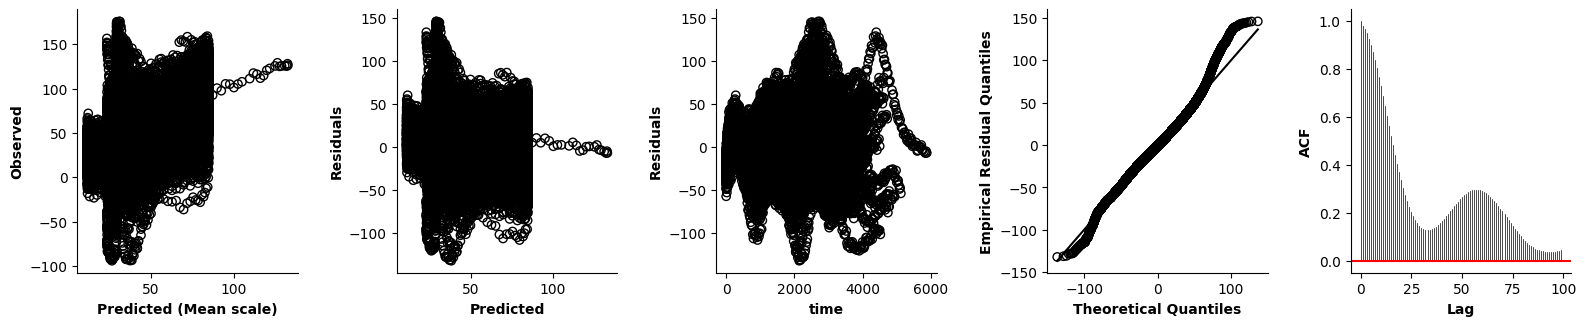

In [14]:
fig = plt.figure(figsize=(5*single_size,single_size),layout='constrained')
axs = fig.subplots(1,5,gridspec_kw={"wspace":0.1})
plot_val(model,pred_viz=["time"],axs=axs,resid_type="Deviance")
plt.show()

In [15]:
# Of course mssm offers all information visualized in the plots above as attributes/via method calls, so that
# you can also make your own plots. Here some examples:

coef, sigma = model.get_pars() # Coef = weights for basis functions, sigma = **variance** of residuals!
pred = model.preds[0] # The model prediction for the entire data, here: a + f(Time)!
mu = model.mus[0] # The predicted mean - this will be identical to pred for the additive model, but this will not be the case for generalized additive models!
res = model.get_resid() # The residuals y_i - \mu_i
y = model.formulas[0].y_flat[model.formulas[0].NOT_NA_flat] # The dependent variable after NAs were removed

Apart from validation plots, `mssmViz` also has functions to visualize the model's estimated smooth terms. Below, we print the estimated smooth of time.

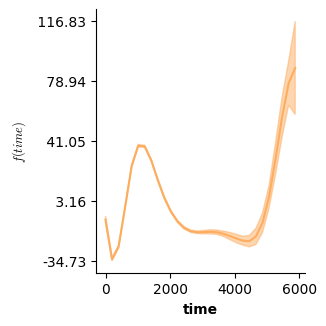

In [16]:
# Plot partial prediction for a single smooth
plot(model,fig_size=(single_size,single_size))

### A by-condition GAM

To get a by-factor model (s(Time,by=cond) in `mgcv`) `mssm` also provides a by keyword! As mentioned above, by default `Formula` dummy-codes factor variables in alphapetical order. Hence, for the `cond` variable "a" will be coded as 0, while "b" will be coded as 1.

In [17]:
# Y = a + b1*c1 + f0(time) + f1(time) + e
# with e ~ N(0,sigma) and c1 == 1 if cond == "b" else 0
# and f0() and f1() representing the smooths over time for
# the first (a) and second (b) level of cond respectively.
formula2 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # One coefficient per dummy-predictor necessary for factor cond - here b
                               f(["time"],by="cond")], # One f(time) term for every level of cond
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:640: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.lhs.variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [18]:
# Fit the model
model2 = GAMM(formula2,Gaussian())
model2.fit(progress_bar=False)

In [19]:
# Again, we print a summary of the edf. per term in the model.
# Note: separate smooths were estimated for each level of "cond" so two edf values are printed.
model2.print_smooth_terms()

f(['time'],by=cond): a; edf: 6.881
f(['time'],by=cond): b; edf: 8.714


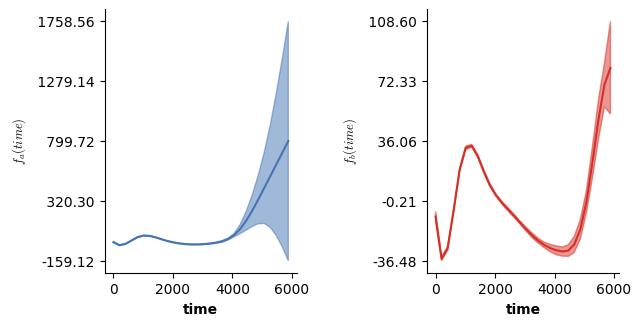

In [20]:
# Partial prediction (using only the f(time)) for all conditions
# Basically what plot(model) does in R in case model was obtained from mgcv
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.1})
plot(model2,axs=axs)
plt.show()

With `mssmViz` we can also look at the predicted difference in the mean between two conditions: `plot_diff` allows us to plot the predicted difference over time between conditions a and b. **Note** that `plot_diff` does by default take into account all terms included in the model, so the offset differences induced by a and b1 are taken into account!!

You can again use the `help` or `print` function, to learn more about the `plot_diff` function:

In [21]:
print(plot_diff.__doc__)

Plots the expected difference (and CI around this expected difference) between two sets of predictions, evaluated for `pred_dat1` and `pred_dat2`.

This function works with all GAMM models, but only supports :class:`mssm.src.python.exp_fam.GAUMLSS` and :class:`mssm.src.python.exp_fam.GAMMALS` `GAMMLSS` models.
`GSMM` models are not supported at all.

This function is primarily designed to visualize the expected difference between two levels of a categorical/factor variable. For example, consider the following
model below, including a separate smooth of "time" per level of the factor "cond". It is often of interest to visualize *when* in time the two levels of "cond" differ
from each other in their dependent variable. For this, the difference curve over "time", essentially the smooth of "time" for the first level subtracted from the
smooth of "time" for the second level of factor "cond" (offset terms can also be accounted for, check the `use` argument), can be visualized together with a

Thus, to visualize the predicted difference we need to set up two data-frames, one per level of "cond". The `plot_diff` function then figures out the rest:

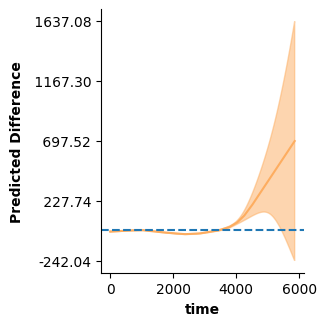

In [22]:
time_pred = [t for t in range(0,max(dat["time"]),20)]
new_dat1 = pd.DataFrame({"cond":["a" for _ in range(len(time_pred))],
                         "time":time_pred})

new_dat2 = pd.DataFrame({"cond":["b" for _ in range(len(time_pred))],
                         "time":time_pred})

# Note, by default `plot_diff` excludes predictor ranges for which one of the two conditions
# contains no values (time > 4000 only exists in cond b). This behavior can be changed with
# the `plot_exist` keyword.
fig = plt.figure(figsize=(single_size,single_size),layout='constrained')
ax = fig.subplots(1,1)
plot_diff(new_dat1,new_dat2,["time"],model2,ax=ax)
ax.axhline(0,linestyle='dashed')
plt.show()

Alternatively, you can also extract the predicted difference yourself, using the model's `predict_diff` method and then create your own plot:

Text(0, 0.5, 'Predicted Difference')

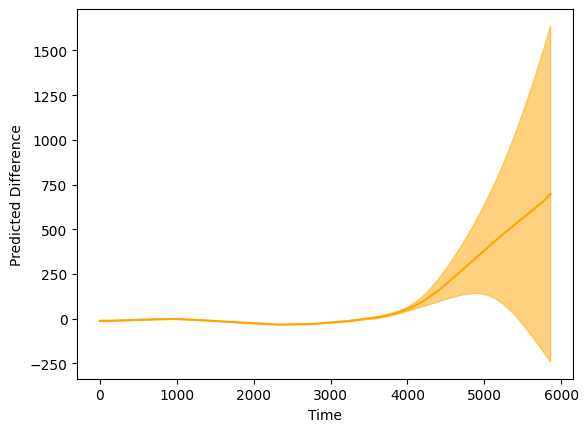

In [23]:
pred_diff,b = model2.predict_diff(new_dat1,new_dat2,use_terms=None)


plt.fill([*new_dat1["time"],*np.flip(new_dat1["time"])],
         [*(pred_diff + b),*np.flip(pred_diff - b)],alpha=0.5,color='orange')
plt.plot(new_dat1["time"],pred_diff,color='orange')
plt.xlabel("Time")
plt.ylabel("Predicted Difference")

### A binary smooth model

If the difference between conditions is of interest it might be more desirable to directly fit a difference curve for specific levels of the factor of interest, rather than plotting the predicted difference. This can be beneficial in case conditions differ in the values of the predictor over which the difference is to be evaluated, because confidence intervals will often be narrower.

We set up such a model below!

In [24]:
formula3 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               f(["time"]), # One f(time) term - will correspond to the baseline level for condition: here let's choose b
                               f(["time"],binary=["cond","a"])], # Another f(time), this one models the difference over time from the other f(time) term for cond=a!
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:640: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.lhs.variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [25]:
# Fit the model
model3 = GAMM(formula3,Gaussian())
model3.fit(progress_bar=False)
model3.print_smooth_terms()

f(['time']); edf: 8.72
f(['time'],by=a); edf: 6.693


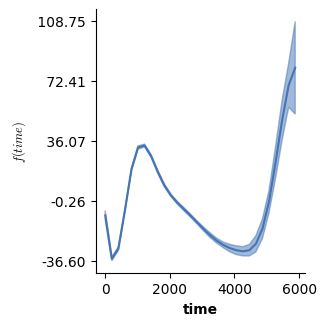

In [26]:
# Let's look at just the f(time) for level b - this one looks just like before!
plot(model3,which=[1],fig_size=(single_size,single_size),prov_cols=0.1)

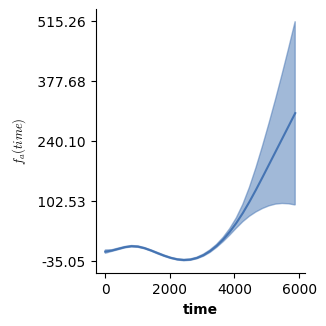

In [27]:
# However, just the prediction from the second f(time) does look a bit different
# now! In fact it represents the difference between the two conditions!
plot(model3,which=[2],fig_size=(single_size,single_size))

If we use all terms we can still predict how y changes over time for both conditions - and thus essentially recover the predictions from model 2! For this we again make use of the `plot_fitted` function, which allows to visualize the combined prediction of multiple terms included in the model (again, see the doc string!)

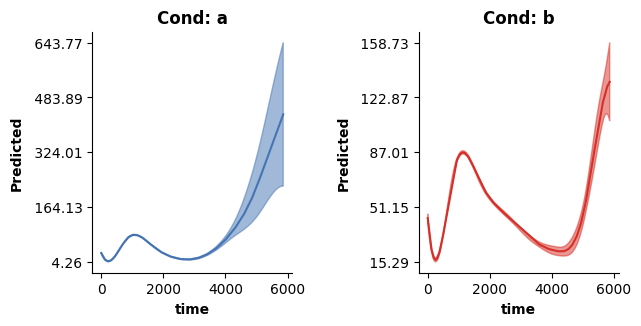

In [28]:
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.1})
cols = [0.1,0.9]
titles = ["Cond: a", "Cond: b"]

for ci,c in enumerate(["a","b"]):
    # Set up some new data for prediction
    time_pred = [t for t in range(0,max(dat["time"]),20)]
    
    new_dat = pd.DataFrame({"cond":[c for _ in range(len(time_pred))],
                            "time":time_pred})
    
    # Now make prediction using all terms
    plot_fitted(new_dat,["time"],model3,ax=axs[ci],col=cols[ci],use=[0,1,2],title=titles[ci])
    
plt.show()

### An ordered factor model

In ``mgcv`` in R, the `by` keyword is sensitive to whether the factor is of type `ordered` or not. This is not the case in ``mssm``, but "ordered factor models" can be implemented nonetheless. As mentioned in the previous section, the syntax for the formula is very similar to the binary model - we just need to create an additional "is_by" variable:

In [29]:
dat["is_a"] = (dat["cond"].values == "a").astype(int)

# We also specify a code-book to recode the model so that we get an offset term for level "a" when adding `l(["cond"])` to the model
codebook = {"cond":{"b":0,"a":1}}

In [30]:
formula3O = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # An offset term - here for level a
                               f(["time"]), # One f(time) term - will correspond to the baseline level for condition: here let's choose b
                               f(["time"],by_cont="is_a")], # Another f(time), this one models the difference over time from the other f(time) term for cond=a but cannot take on a constant!
                        data=dat,
                        codebook=codebook)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:640: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.lhs.variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [31]:
model3O = GAMM(formula3O,Gaussian())
model3O.fit(progress_bar=False)

In [32]:
model3O.print_parametric_terms()

Intercept: 52.878, t: 211.867, DoF.: 29197, P(|T| > |t|): 0.000e+00 ***
cond_a: -14.002, t: -29.029, DoF.: 29197, P(|T| > |t|): 0.000e+00 ***

Note: p < 0.001: ***, p < 0.01: **, p < 0.05: *, p < 0.1: .


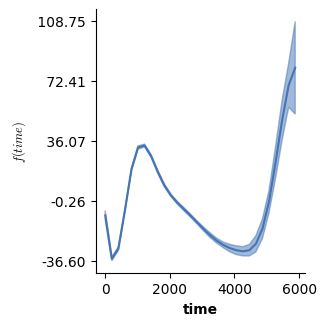

In [33]:
# Let's look at just the f(time) for level b - this one again looks just like before!
plot(model3O,which=[2],fig_size=(single_size,single_size),prov_cols=0.1)

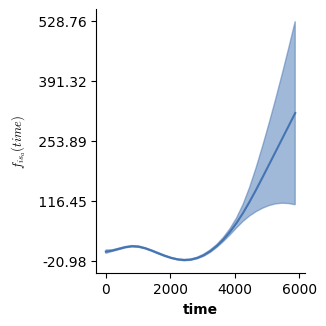

In [34]:
# The predicted effect of the second smooth `f(["time"],by_cont="is_a")`:
plot(model3O,which=[3],fig_size=(single_size,single_size),prov_cols=0.1)

The predicted effect of the second smooth `f(["time"],by_cont="is_a")` looks very similar to the binary smooth from model 3 - the difference is a different offset shift. To understand what is goind on, remember that both `f(["time"],by_cont="is_a")` in model 3O and `f(["time"],binary=["cond","a"])` in model 3 are difference curves. The distinction is that the latter can include an offset shift, while the former does not. In model 3O, this offset shift is added back in by the `l(["cond"])` term:

In [35]:
model3O.print_parametric_terms()

Intercept: 52.878, t: 211.867, DoF.: 29197, P(|T| > |t|): 0.000e+00 ***
cond_a: -14.002, t: -29.029, DoF.: 29197, P(|T| > |t|): 0.000e+00 ***

Note: p < 0.001: ***, p < 0.01: **, p < 0.05: *, p < 0.1: .


If you add -14.002 to the estimate for `f(["time"],by_cont="is_a")`, you essentially end up again with the estimated effect for `f(["time"],binary=["cond","a"])`. **Note**, that while that is true in this simple model, this is not generally the case - depending on how you set up the ordered factor smooths.

### Tensor smooth interactions

Non-linear interactions between continuous variables are supported via tensor smooth interactions (see Wood, 2006; Wood, 2017). Both the behavior achieved by the `ti()` and `te()` terms in `mgcv` is supported. Let's start with considering the `te()` term behavior!

In [36]:
formula4 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # Offset for cond='b'
                               f(["time","x"],by="cond",te=True)], # one smooth surface over time and x - f(time,x) - per level of cond: three-way interaction!
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:640: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.lhs.variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [37]:
# Fit the model
model4 = GAMM(formula4,Gaussian())
model4.fit(progress_bar=False)

# We end up with two smooth terms - one surface for every level of cond.
model4.print_smooth_terms()

f(['time', 'x'],by=cond): a; edf: 7.507
f(['time', 'x'],by=cond): b; edf: 8.84


We can now visualize the smooth functions. For this we can again use the `plot` function. **Remember**: the plot function only visualizes the estimated smooth terms, it ignores all other terms. That is, in this example the smooth functions are **not** shifted up/down by the intercept and offset adjustment for level "b" of factor "cond".

**Note**: the shaded areas in the plot below correspond to areas outside of a (by default 95%) credible interval.

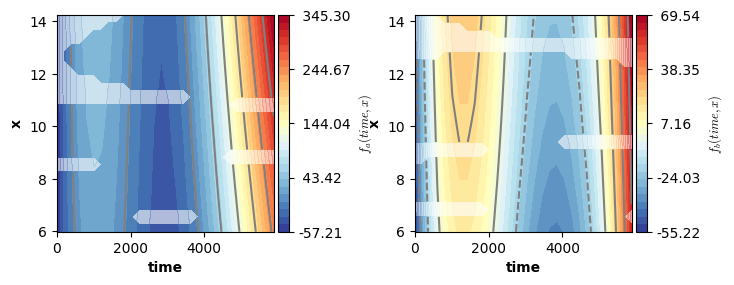

In [38]:
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.3})
plot(model4,axs=axs)
plt.show()

The ti() term in mgcv enables decomposing smooth interactions into separate interaction (including lower order interactions) and main effects! In ``mssm`` this is achieved by omitting the `te=True` argument (the default). In that case, separate smooth terms have to be included for the lower order interactions, just like in `mgcv`:

In [39]:
formula5 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # Offset for cond='b'
                               f(["time"],by="cond"), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond")], # one smooth surface over time and x - f(time,x) - per level of cond: three-way interaction!
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:640: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.lhs.variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [40]:
# Fit the model
model5 = GAMM(formula5,Gaussian())
model5.fit(progress_bar=False)

# We end up with a total of 6 smooth terms in this model!
model5.print_smooth_terms()

f(['time'],by=cond): a; edf: 6.88
f(['time'],by=cond): b; edf: 8.716
f(['x'],by=cond): a; edf: 1.042
f(['x'],by=cond): b; edf: 1.202
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 1.0


We can now visualize the partial main & interaction effects:

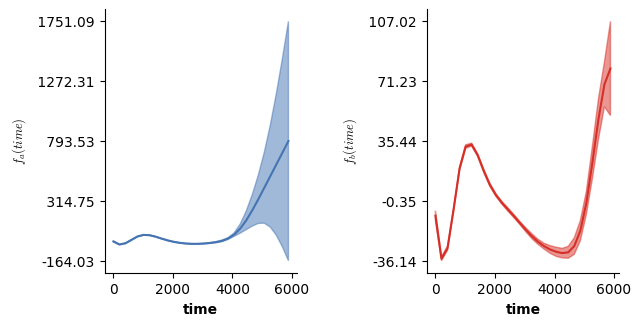

In [41]:
# Visualizing the partial main effects of time.
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.1})
plot(model5,which=[2],axs=axs,ci=True)
plt.show()

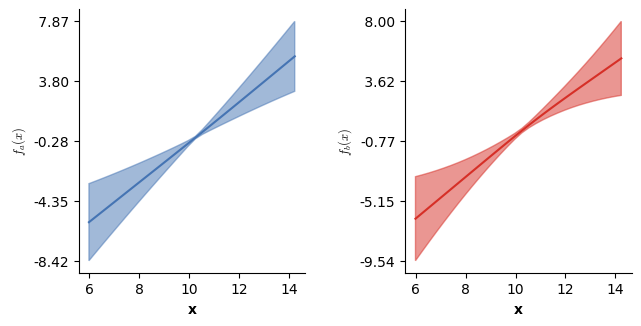

In [42]:
# Visualizing the partial main effects of x.
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.1})
plot(model5,which=[3],axs=axs,ci=True)
plt.show()

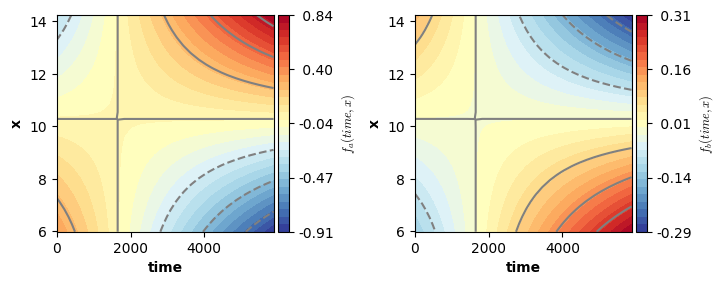

In [43]:
# Visualizing the partial interaction:
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.3})
plot(model5,which=[4],axs=axs,ci=False)
plt.show()

Note, that these surfaces really covers only the three-way interaction estimates (ignoring the main effects). Hence, they look very different from the previous plots. However, we can still recover (**approximately**) the surfaces estimated by model 4, when visualizing the three-way interaction + the two-way interactions!

In this case, the added interactions produce surfaces comparable to those obtained from model 4. This is not guaranteed, and in practice models set up like model 5 will tend to produce more flexible solutions - because they have a larger solution space, in which they might find evidence for a more complex solution (see Wood, 2017).

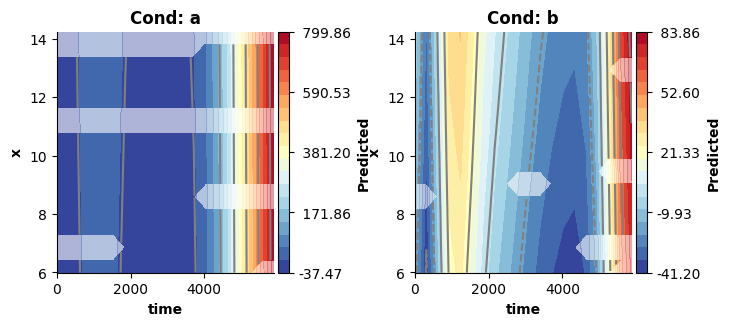

In [44]:
# Visualizing the three-way interaction + the two-way interactions approximates the surfaces estimated by model4, which did not attempt to decompose these.
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.3})
titles = ["Cond: a", "Cond: b"]

# Set up some new data for prediction
time_pred = []
x_pred = []

xr = [t for t in np.linspace(min(dat["x"]),max(dat["x"]),20)]
tr = np.linspace(0,max(dat["time"]),len(xr))

for t in tr:
    for x in xr:
        time_pred.append(t)
        x_pred.append(x)

# Loop over conditions
for ci,c in enumerate(["a","b"]):
    

    new_dat = pd.DataFrame({"x":x_pred,
                            "cond":[c for _ in range(len(x_pred))],
                            "time":time_pred})
    
    plot_fitted(new_dat,["time","x"],model5,ax=axs[ci],use=[2,3,4],title=titles[ci])
    
plt.show()

### Binary tensor smooth interactions
The binary smooth approach generalizes beyond the univariate case to the tensor smooth interaction case. Essentially, we then fit a smooth surface for the reference level and difference surfaces for the remaining levels of a factor. Such a model is set up below.

In [45]:
formula6 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               f(["time","x"],te=True), # one smooth surface over time and x - f(time,x) - for the reference level = cond == b
                               f(["time","x"],te=True,binary=["cond","a"])], # another smooth surface over time and x - f(time,x) - representing the difference from the other surface when cond==a
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:640: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.lhs.variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [46]:
# Fit the model
model6 = GAMM(formula6,Gaussian())
model6.fit(progress_bar=False)

# We again end up with two smooth terms in the model.
model6.print_smooth_terms()

f(['time', 'x']); edf: 8.499
f(['time', 'x'],by=a); edf: 8.128


Visualizing the two surfaces reveals the same picture visibile for the univariate case: the left surface largely matches the surface estimated by
model 4! The right surface is now the difference surface estimated for condition a and thus needs to be added to the surface on the left to get the combined surface for condition a!

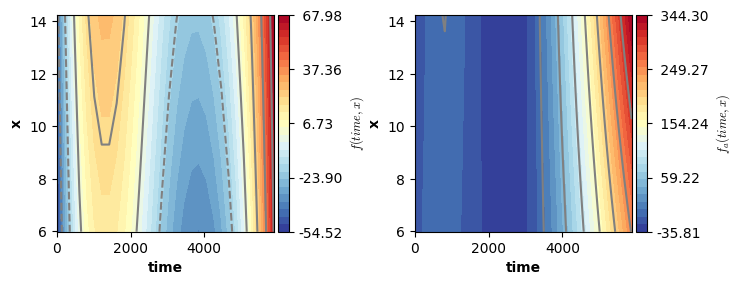

In [47]:
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.3})
plot(model6,which=[1],axs=[axs[0]],ci=False)
plot(model6,which=[2],axs=[axs[1]],ci=False)
plt.show()

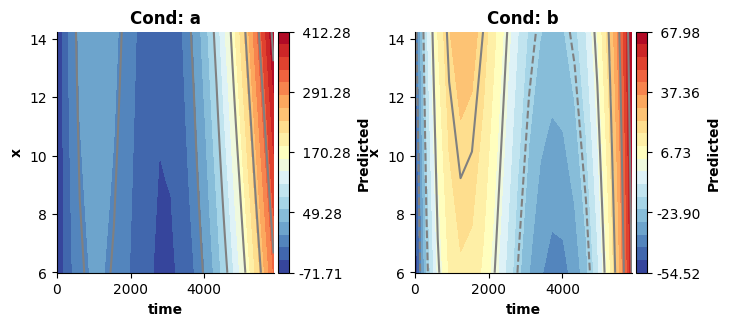

In [48]:
# Hence, to recover the actual surfaces for both conditions we need to add them together when cond == "a"
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.3})
titles = ["Cond: a", "Cond: b"]

# Set up some new data for prediction
time_pred = []
x_pred = []

xr = [t for t in np.linspace(min(dat["x"]),max(dat["x"]),20)]
tr = np.linspace(0,max(dat["time"]),len(xr))

for t in tr:
    for x in xr:
        time_pred.append(t)
        x_pred.append(x)

# Loop over conditions
for ci,c in enumerate(["a","b"]):
    

    new_dat = pd.DataFrame({"x":x_pred,
                            "cond":[c for _ in range(len(x_pred))],
                            "time":time_pred})
    
    plot_fitted(new_dat,["time","x"],model6,ax=axs[ci],use=[1,2],title=titles[ci],ci=False)
    
plt.show()

### Random effects
As mentioned above we can also include random intercepts, random slopes, and random smooths into any `mssm` model!

#### Random Intercepts

To model a random intercept (e.g., per subject or item), simply add an `ri` term:

In [49]:
formula7a = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond"), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond"), # three-way interaction
                               ri("sub")], # Random intercept for each subject
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:640: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.lhs.variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [50]:
# Fit the model
model7a = GAMM(formula7a,Gaussian())
model7a.fit(progress_bar=False)
model7a.print_smooth_terms()

f(['time'],by=cond): a; edf: 6.906
f(['time'],by=cond): b; edf: 8.753
f(['x'],by=cond): a; edf: 1.0
f(['x'],by=cond): b; edf: 1.074
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 1.0
ri(sub); edf: 18.966


You can extract the estimated random intercepts using the ``get_term_coef`` function, which returns the coefficients (and their identifiers/names) associated with a specific term in the formula (here term 5, corresponding to the random intercept term):

In [51]:
rand_int,rand_int_names = get_term_coef(model7a,[5])

for ric,rin in zip(rand_int[:5],rand_int_names[:5]):
    print(f"{rin}: {ric[0]}")

ri_sub_0: -22.41795450863589
ri_sub_1: 16.58503368875314
ri_sub_2: -21.77295808071503
ri_sub_3: -0.9703295327360588
ri_sub_4: 4.129825866788417


#### Random Slopes

Many different random slope combinations are possible - but they are all achieved with the `rs` term. Check the doc-string for the `rs` term for different examples. Below
we estimate a random intercept per subject (achieved with the `ri` term) and also a random slope of time (achieved with the `rs` term) - with a separate variance parameter per condition:

In [52]:
formula7b = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond"), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond"), # three-way interaction
                               ri("sub"), # Random intercept for each subject
                               rs(["time","cond"],rf="sub")], # Random slope of time for subject - separate ones for each level of cond
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:640: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.lhs.variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [53]:
# Fit the model
model7b = GAMM(formula7b,Gaussian())
model7b.fit(progress_bar=False)
model7b.print_smooth_terms()

f(['time'],by=cond): a; edf: 6.912
f(['time'],by=cond): b; edf: 8.832
f(['x'],by=cond): a; edf: 1.221
f(['x'],by=cond): b; edf: 1.0
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 1.0
ri(sub); edf: 16.826
rs(['time', 'cond'],sub):0; edf: 18.869
rs(['time', 'cond'],sub):1; edf: 18.913


The ``get_term_coef`` function can again be used to obtain the estimated random slopes. Note, that the function returns a single array even though separate sets of random slopes were estimated per level of "cond": The first 20 (here "sub" had 20 levels, i.e., there were 20 subjects) elements in this array will correspond to the random slopes estimated for the first level of "cond", the next 20 to the second level, and so on. To check which level of "cond" was treated as the "first level" you can inspect the codebook again, via ``formula.get_factor_codings()``.

Since the function also returns the name of each coefficient, you can also inspect those.

In [54]:
rand_slopes,rand_slope_names = get_term_coef(model7b,[6])

for rsc,rsn in zip(rand_slopes[:5],rand_slope_names[:5]):
    print(f"{rsn}: {rsc[0]}")

time_cond_a_0: -0.013782446781787246
time_cond_a_1: 0.008196035845600032
time_cond_a_2: -0.016399453706801445
time_cond_a_3: 0.001340474262813463
time_cond_a_4: 0.002367963871086467


#### Random Smooths

GAMMs also allow to decompose the mean into a non-linear fixed part and a non-linear random part - e.g., a general smooth trend over time and factor-level-specific non-linear deviations from it. Additive models estimate the latter as **random smooth terms**:

In [55]:
formula7c = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond"), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond"), # three-way interaction
                               fs(["time"],rf="sub")], # Random smooth for each subject
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:640: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.lhs.variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [56]:
# Fit the model
model7c = GAMM(formula7c,Gaussian())
model7c.fit(progress_bar=False)
model7c.print_smooth_terms()

f(['time'],by=cond): a; edf: 6.892
f(['time'],by=cond): b; edf: 8.635
f(['x'],by=cond): a; edf: 1.218
f(['x'],by=cond): b; edf: 1.001
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 1.001
f(['time'],by=sub); edf: 131.86


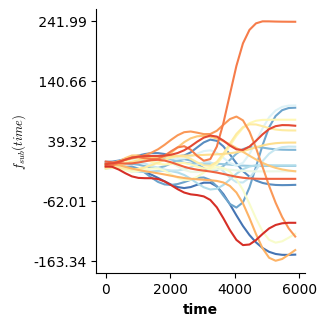

In [57]:
# Subject difference smooths - is there a subject-specific difference from the general trend?
plot(model7c,which=[5],fig_size=(single_size,single_size))

In the R-package `mgcv` it is common to estimate random smooth terms with separate smoothing penalties for different levels of an additional experimental factor (e.g., cond). In `mssm` this is achieved with the following syntax (see the conversion table above for an alternative syntax involving the ``by_cont`` keyword of `fs`):

In [58]:
# First we have to create a factor in our data that separates subjects between different levels (i.e., the interaction of the factor cond and sub):
dat["sub_cond"] = dat["cond"].astype(str) + dat["sub"].astype(str)

In [59]:
# Now we can specify the formula:
formula7d = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond"), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond"), # three-way interaction
                               fs(["time"],rf="sub_cond",by_subgroup=["cond","a"]), # Random smooth for each subject for group a of factor cond
                               fs(["time"],rf="sub_cond",by_subgroup=["cond","b"])], # Random smooth for each subject for group b of factor cond
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:640: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.lhs.variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [60]:
# Fit the model
model7d = GAMM(formula7d,Gaussian())
model7d.fit(progress_bar=False)
model7d.print_smooth_terms()

f(['time'],by=cond): a; edf: 6.894
f(['time'],by=cond): b; edf: 8.523
f(['x'],by=cond): a; edf: 1.069
f(['x'],by=cond): b; edf: 1.069
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 1.0
f(['time'],by=sub_cond): a; edf: 87.001
f(['time'],by=sub_cond): b; edf: 134.415


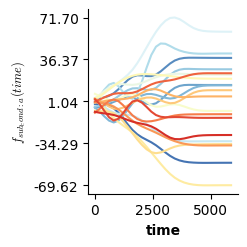

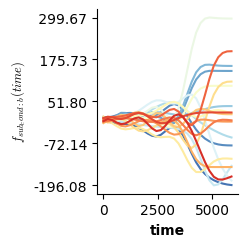

In [61]:
# Now we get to sets of subject difference smooths - one per level of "cond":
plot(model7d,which=[5,6])

### Very big random effect models

`mssm` is particularly well suited to fit big random effect structures. The model below estimates a non-linear random smooth of time for every individual series in the dataframe - each being parameterized with 20 basis functions.

In [62]:
len(np.unique(dat["series"])) # 200 non-linear curves will be estimated by the random effect.

200

In [63]:
formula9 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond"), # to-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # to-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond"), # three-way interaction
                               fs(["time"],rf="series",nk=20)], # Random non-linear effect of time - one smooth per level of factor series
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:640: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.lhs.variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


Note, that we set the ``method`` argument to "Chol" in the call to the ``fit`` method below. This is slightly less stable than the default QR approach, but usually not problematically so when we have sufficient data. ``mssm`` by default will issue a warning if it detects that using the Cholesky approach might result in inaccuracies. In that case you really should switch back to ``method='QR'``.

In [64]:
# Fit the model
model9 = GAMM(formula9,Gaussian())
model9.fit(method="Chol",progress_bar=False)
model9.print_smooth_terms()

f(['time'],by=cond): a; edf: 5.819
f(['time'],by=cond): b; edf: 8.164
f(['x'],by=cond): a; edf: 1.39
f(['x'],by=cond): b; edf: 1.645
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 1.211
f(['time'],by=series); edf: 2414.917


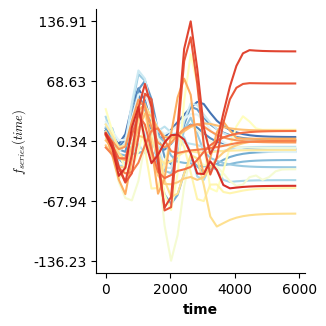

In [65]:
# Series difference smooths - is there a series-specific difference from the general trend?
plot(model9,which=[5],fig_size=(single_size,single_size))

This model finally achieves reasonable model fit - meeting the model assumptions. Note that when modeling multi-level neuro-physiological time-series data in particular it will often be necessary to have trial-level random effect terms to ensure that the assumptions can be met. An "ar1" model is sometimes an alternative, and we will look into that in the "Advanced topics" section!

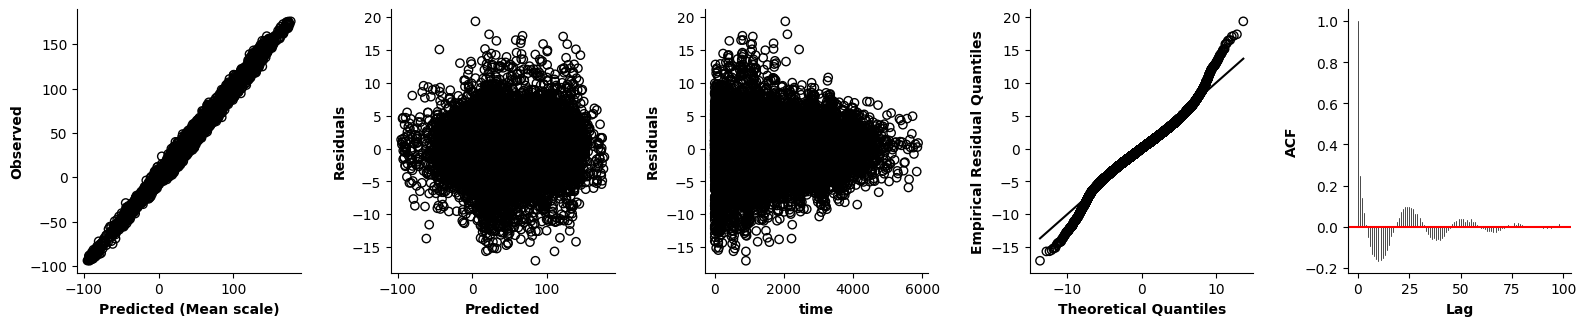

In [66]:
fig = plt.figure(figsize=(5*single_size,single_size),layout='constrained')
axs = fig.subplots(1,5,gridspec_kw={"wspace":0.1})
plot_val(model9,pred_viz=["time"],axs=axs,resid_type="Deviance")
plt.show()

## Beyond Gaussian Models: Estimating GAMMs and GAMMLSS in `mssm`

So far we have worked with strictly additive models - this was sufficient to get familiar with the `Formula` syntax. In a strictly additive model, we assume that our response variables $Y_i \sim N(\mu_i,\sigma)$, where $\mu_i$ is the model prediction for observation $y_i$ (i.e., realization of $Y_i$). A **Generalized** additive model allows to replace the normal distribution with $\mathcal{E}$ - denoting any member of the exponential family of distributions - so that $Y_i \sim \mathcal{E}(\mu_i,\phi)$. $\mu_i$ is usually modelled through a known (link) function $g(\mu_i) = \eta_i = \mathbf{X}\boldsymbol{\beta}$ with $\eta_i$ commonly being referred to as the "linear predictor" (since the additive or linear model is specified for $\eta$).

`mssm` currently supports Binomial, Gamma, Inverse Gaussian, and Poisson models. To estimate any non-normal GAMM, all that is necessary in `mssm` is to replace the `Gaussian` with any other `Family` supported by `mssm`. All families come with default choices for the link functions. You can consult the documentation for details and specific aspects of all families. The documentation also tells you the format expected of response variable. The `Binomial` family for example assumes that whatever variable is specified as response variable (e.g., "y" in the examples here) - holds **observed proportions** (of course this will be just 0s and 1s for binary data). Below we present a few examples involving GAMMs with different families. Afterwards we look at GAMMLSS models.

### Examples: GAMMs

#### Binomial GAM

For the implementation of the `Binomial` family `mssm` assumes that we have collected proportions of success, i.e., the dependent variables specified in the model `Formula` needs to hold **observed proportions and not counts**!

If we assume that each observation $y_i$ reflects a single independent draw from a binomial, (with $n=1$, and $p_i$ being the probability that the result is 1) then the dependent variable should either hold 1 or 0. If we have multiple independent draws from the binomial per observation (i.e., row in our data-frame), then $n$ will usually differ between observations/rows in our data-frame (i.e., we observe $k_i$ counts of success out of $n_i$ draws - so that $y_i=k_i/n_i$). In that case, the `Binomial()` family accepts a vector for argument `n` (which is simply set to 1 by default, assuming binary data), containing $n_i$ for every observation $y_i$.

Below we simulate data for a Binomial GAM:

In [67]:
# Data for Binomial model assumes proportions as DV - for binary this will simply be 0s and 1s.
Binomdat = sim3(10000,2,family=Binomial(),binom_offset=-5)
print(Binomdat.head())
print(np.unique(Binomdat["y"],return_counts=True))

   y        x0        x1        x2        x3       eta
0  1  0.905133  0.417219  0.129225  0.315450  3.299590
1  0  0.186302  0.236379  0.737636  0.395635  0.010155
2  0  0.536860  0.486592  0.019345  0.378282 -0.307494
3  1  0.628200  0.857693  0.801225  0.503011  3.477006
4  0  0.548359  0.077059  0.820902  0.745119 -1.103242
(array([0, 1]), array([2198, 7802]))


Fitting the model should now feel quite familiar - all we need to do is specify a `Formula` and model. The latter now needs to be set up with the `Binomial` family.

In [68]:
# Now we can again specify the model.
binom_formula = Formula(lhs("y"),[i(),f(["x0"]),f(["x1"]),f(["x2"]),f(["x3"])],data=Binomdat)

# By default, the Binomial family assumes binary data and uses the logit link.
binom_model = GAMM(binom_formula,Binomial())
binom_model.fit(progress_bar=False)

The `plot` function from `mssmViz` continues to function just like before as well. Importantly, the `plot` function always visualizes effects on the scale of the linear predictor (i.e., here for the log-odds of success). For strictly additive Gaussian models, $\mu_i = \eta_i$, but this is no longer the case for Generalized models - so keep that in mind for your interpretation of the visualized effects!

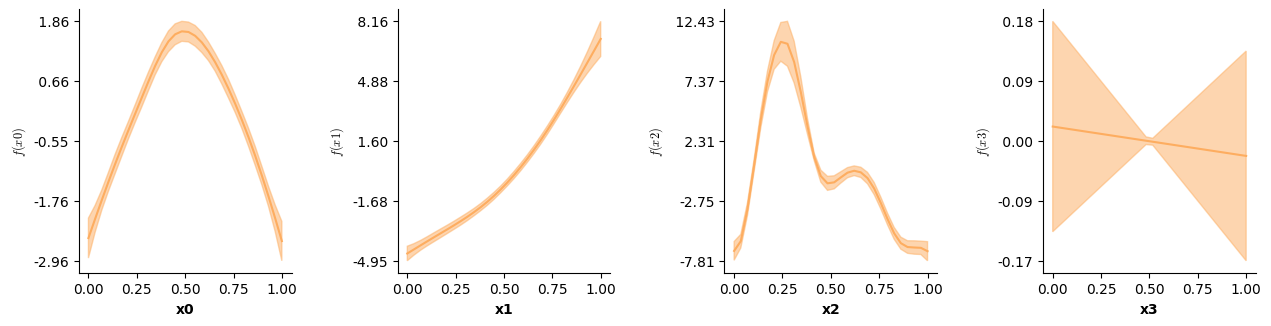

In [69]:
# Let's take a look at predictions on the scale of the log-odds
fig = plt.figure(figsize=(4*single_size,single_size),layout='constrained')
axs = fig.subplots(1,4,gridspec_kw={"wspace":0.1})
plot(binom_model,axs=axs)
plt.show()

All `GAMM` functions remain applicable for different families. For example, you can still get p-values for the smooth terms of the Binomial model - but the Null distribution is now automatically adjusted to be a $\chi^2$ distribution, since no scale parameter is estimated for the Binomial model (see Wood, 2017).

In [70]:
binom_model.print_smooth_terms(p_values=True)

f(['x0']); edf: 5.193 chi^2: 579.679 P(Chi^2 > chi^2) = 0.000e+00 ***
f(['x1']); edf: 3.944 chi^2: 1131.469 P(Chi^2 > chi^2) = 0.000e+00 ***
f(['x2']); edf: 8.69 chi^2: 1320.676 P(Chi^2 > chi^2) = 0.000e+00 ***
f(['x3']); edf: 1.0 chi^2: 0.075 P(Chi^2 > chi^2) = 0.78413

Note: p < 0.001: ***, p < 0.01: **, p < 0.05: *, p < 0.1: . p-values are approximate!


#### Gamma GAM

Below we simulate data for a Gamma Gam. We assume: $Y_i \sim \Gamma(\mu_i,\phi)$. The Gamma distribution is usually not expressed in terms of the mean and scale ($\phi$) parameter
but rather in terms of a shape and rate parameter - called $\alpha$ and $\beta$ respectively. Wood (2017) provides $\alpha = 1/\phi$. With this we can obtain $\beta = 1/\phi/\mu$ (see the doc-string for the `Gamma` family for details).

In [71]:
# Data for Gamma model looks just like for Gaussian - except that y cannot hold negative values!
Gammadat = sim3(500,2,family=Gamma(),seed=0)
print(Gammadat.head())
print(min(Gammadat["y"]))

             y        x0        x1        x2        x3       eta
0    12.379666  0.636962  0.081324  0.013008  0.048017  3.013629
1  2060.005457  0.269787  0.875228  0.827763  0.656338  7.909459
2  5235.301228  0.040974  0.941706  0.496243  0.011885  9.587705
3    68.708860  0.016528  0.261864  0.435918  0.052403  5.189689
4   366.684112  0.813270  0.012101  0.601795  0.023161  5.339632
0.013611044551897237


In [72]:
# Now we can specify the model.
gamma_formula = Formula(lhs("y"),[i(),f(["x0"]),f(["x1"]),f(["x2"]),f(["x3"])],data=Gammadat)

# By default, the Gamma family assumes that the model predictions match log(\mu_i), i.e., a log-link is used.
gamma_model = GAMM(gamma_formula,Gamma())
gamma_model.fit(progress_bar=False)

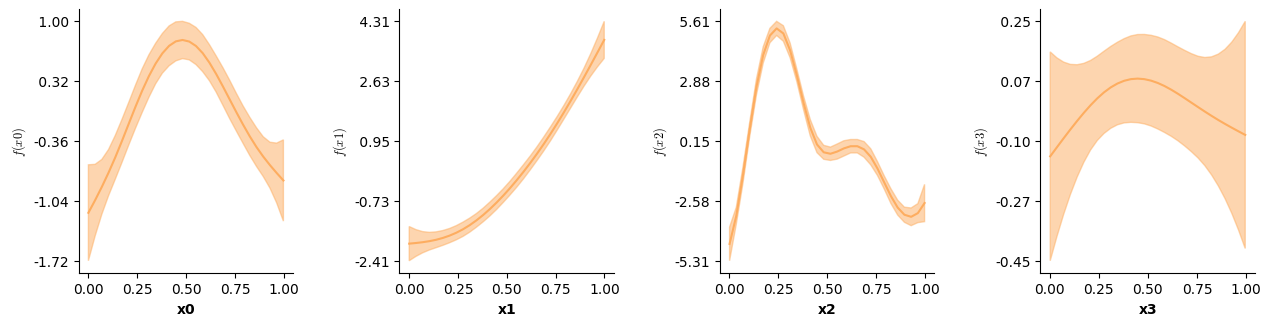

In [73]:
# Remember: by default the effects are plotted on the scale of the linear predictor - here it is the log of the mean
fig = plt.figure(figsize=(4*single_size,single_size),layout='constrained')
axs = fig.subplots(1,4,gridspec_kw={"wspace":0.1})
plot(gamma_model,axs=axs)
plt.show()

Model validation remains just as crucial for GAMMS as it was for AMMS! We can check the model by inspecting standardized (deviance) residuals (see Wood, 2017 for details) - if the model is correctly specified, we can expect those to behave approximately like $N(0,\phi)$!
So the same plots we looked at for the Gaussian model remain relevant - and can again be visualized using the `plot_val` function from `mssmViz`.

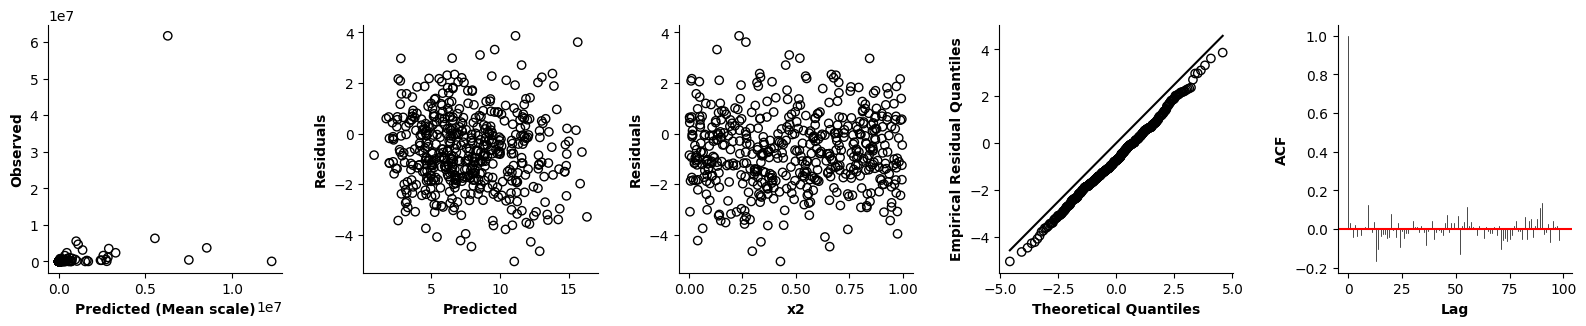

In [74]:
fig = plt.figure(figsize=(5*single_size,single_size),layout='constrained')
axs = fig.subplots(1,5,gridspec_kw={"wspace":0.1})
plot_val(gamma_model,pred_viz=["x2"],resid_type="Deviance",axs=axs)
plt.show()

### Examples: Generalized Additive Models of Location Scale and Shape

GAMMs are already more flexible than AMMS and come in handy if we cannot assume that the variance in our RVs $Y_i$ remains constant. However, they are still quite restrictive in that they restrict the variance to change according to a (often relatively simple) function of the mean of and because they assume that the scale parameter and any other distribution parameter are shared between observations (see Rigby & Stasinopoulos, 2005 for a discussion). 

The answer to these problems are Generalized Additive Models of Location, Scale and Shape (GAMMLSS models; Rigby & Stasinopoulos, 2005), in which we model some or even all parameters of the response distributions, not just the mean, as additive combinations of smooth functions and other parametric terms. That is, we assume $Y_i \sim \mathcal{E}(\mu_i,\phi_i,...,\tau_i)$ For example, in time-series modeling we might assume that our RVs are $Y_i \sim N(\mu_i,\sigma_i)$ - where both $\mu_i$ and $\sigma_i$ change smoothly as a (potentially differently shaped) function of time. Note, that this allows modeling very different patterns of heteroscedasticity - also those that might not easily be captured by modeling the variance as a simple function of the mean.

`mssm` currently supports Normal models ($\mu$ and $\sigma$ can be modelled), Gamma models ($\mu$ and $\phi$ can be modeled), and Multinomial models (Probability of $Y_i$ taking one one of $K$ values can be modelled).

#### Gaussian GAMMLSS

Below we simulate data for a Gaussian GAMMLSS model. Both the mean and the standard deviation of $Y_i$ change as a function of variable x0. Setting up a GAMMLSS model in `mssm` is not much more work than setting up a GAM. The main difference is that multiple formulas need to be provided - one per distributional parameter of the family.

In [75]:
# Simulate 1000 data points
GAUMLSSDat = sim6(1000,seed=20)

# We need to model the mean: \mu_i = \alpha + f(x0)
formula_m = Formula(lhs("y"),
                    [i(),f(["x0"])],
                     data=GAUMLSSDat)

# and the standard deviation as well: log(\sigma_i) = \alpha + f(x0)
formula_sd = Formula(lhs("y"),
                    [i(),f(["x0"])],
                     data=GAUMLSSDat)

# Collect both formulas
formulas = [formula_m,formula_sd]

# Create Gaussian GAMMLSS family with identity link for mean
# and log link for sigma
family = GAUMLSS([Identity(),LOGb(-0.0001)])

# Now define the model and fit!
gaumlss_model = GAMMLSS(formulas,family)
gaumlss_model.fit(progress_bar=False)

The `plot` function from the `mssmViz` package also supports GAMMLSS models, and can be used to visualize the estimated effects for individual distribution parameters (e.g., $\mu$ and $\phi$):

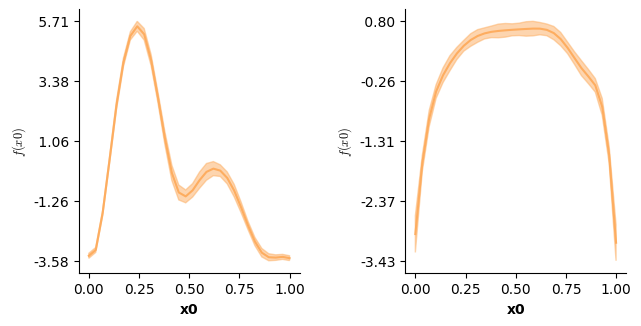

In [76]:
# Now we can visualize the estimated shape of f(x0) for both the mean and standard deviation parameter
# as well as approximate CIs for both.
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.1})
plot(gaumlss_model,dist_par=0,axs=[axs[0]])
plot(gaumlss_model,dist_par=1,axs=[axs[1]])
plt.show()

Also for GAMMLSS models we need to check the validity of the model. The `plot_val` function by default plots standardized residuals for GAMMLSS models - these should be $N(0,1)$ if the model is correct (see `plot_val` doc-string and Rigby & Stasinopoulos, 2005):

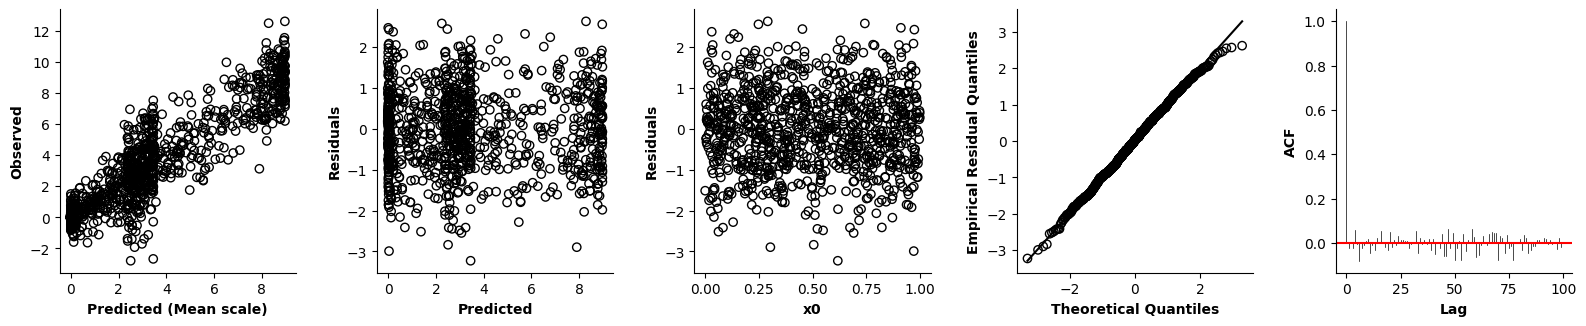

In [77]:

fig = plt.figure(figsize=(5*single_size,single_size),layout='constrained')
axs = fig.subplots(1,5,gridspec_kw={"wspace":0.1})

# By default, the plot_val function omits the predicted vs. observed plot for more general models - but for Gaussian and Gamma GAMMLSS it is still useful, so we set `obs=True` to get it.
plot_val(gaumlss_model,pred_viz=["x0"],obs=True,axs=axs)
plt.show()

The model presented above is rather simple - but `mssm` also readily handles more complex GAMMLSS models. Below we simulate a more complex model involving random smooth terms for 20 simulated subjects and then estimate the model from 5000 observations. This only takes a couple of seconds or so.

In [78]:
sim_dat = sim12(5000,c=0,seed=0,family=GAUMLSS([Identity(),LOG()]),n_ranef=20)

# We again need to model the mean: \mu_i = \alpha + f(x0) + f(x1) + f_{x4}(x0)
sim_formula_m = Formula(lhs("y"),
                    [i(),f(["x0"]),f(["x1"]),fs(["x0"],rf="x4")],
                    data=sim_dat)

# and the standard deviation as well: log(\sigma_i) = \alpha + f(x2) + f(x3)
sim_formula_sd = Formula(lhs("y"),
                    [i(),f(["x2"]),f(["x3"])],
                    data=sim_dat)

# Now define the model and fit!
gaumlss_model2 = GAMMLSS([sim_formula_m,sim_formula_sd],family)
gaumlss_model2.fit(progress_bar=False)

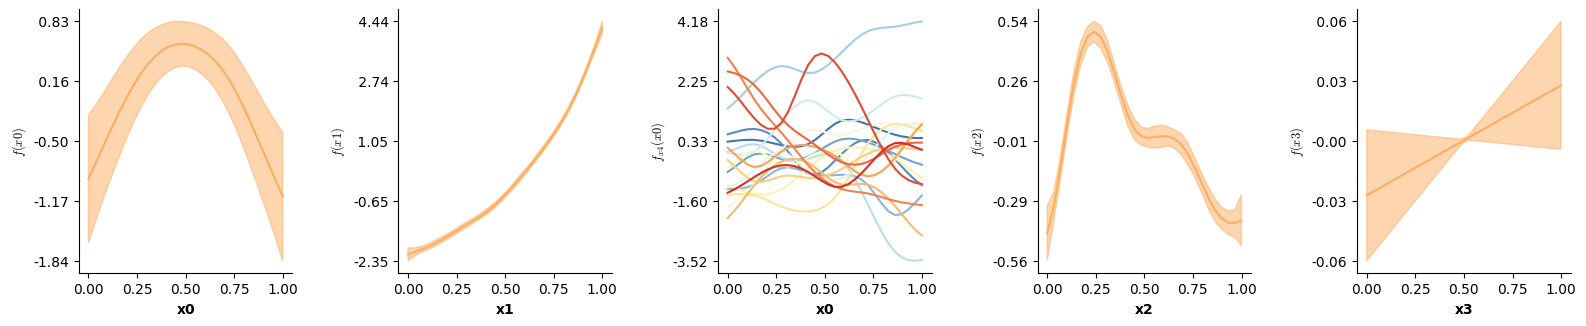

In [79]:
fig = plt.figure(figsize=(5*single_size,single_size),layout='constrained')
axs = fig.subplots(1,5,gridspec_kw={"wspace":0.1})
plot(gaumlss_model2,axs=axs[:3])
plot(gaumlss_model2,axs=axs[3:],dist_par=1)

#### GAMMA GAMMLSS

We now simulate the $Y_i$ with a Gamma distribution - both mean and scale parameter of the Gamma again vary as a function of x0.

In [80]:
# Simulate 1000 data points
GAMMALSSDat = sim6(1000,family=GAMMALS([LOG(),LOG()]),seed=20)

# We need to model the mean: \mu_i = \alpha + f(x0)
formula_m = Formula(lhs("y"),
                    [i(),f(["x0"])],
                     data=GAMMALSSDat)

# and the scale parameter as well: log(\scale_i) = \alpha + f(x0)
formula_sd = Formula(lhs("y"),
                    [i(),f(["x0"])],
                     data=GAMMALSSDat)

# Collect both formulas
formulas = [formula_m,formula_sd]

# Create Gamma GAMMLSS family with log link for mean
# and log link for sigma
family = GAMMALS([LOG(),LOGb(-0.01)])

# Now define the model and fit!
gammalss_model = GAMMLSS(formulas,family)
gammalss_model.fit(progress_bar=False)

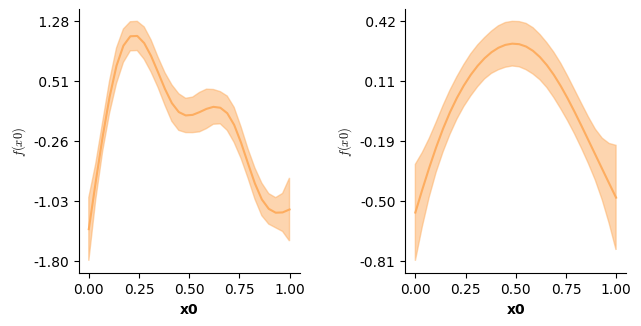

In [81]:
# Now we can again visualize the estimated shape of f(x0) for both the mean and scale parameter
# as well as approximate CIs for both.
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.1})
plot(gammalss_model,dist_par=0,axs=[axs[0]])
plot(gammalss_model,dist_par=1,axs=[axs[1]])
plt.show()

#### Multinomial GAMMLSS

The final GAMMLSS example is for a multinomial model. This Family assumes that each observation $y_i$ corresponds to one of $K$ classes (labeled as 0,...,$K$) and reflects a
realization of an independent RV $Y_i$ with probability mass function defined over the $K$ classes. These K probabilities - that $Y_i$ takes on class 0,...,$K$ - are modeled as additive combinations of smooth functions of covariates and other parametric terms. This model can thus be used to perform multi-label classification!

Below we simulate for a Multinomial model with 5 classes - with the probability of $Y_i$ taking on any of these classes changing as a function of variable X0.

In [82]:
# Simulate data
MULNOMDAT = sim5(1000,seed=34)

# We need to specify K-1 formulas - see the `MULNOMLSS` docstring for details.
formulas = [Formula(lhs("y"),
                    [i(),f(["x0"])],
                     data=MULNOMDAT) for k in range(4)]

# Create family - again specifying K-1 pars - here 4!
family = MULNOMLSS(4)

# Fit the model
model = GAMMLSS(formulas,family)
model.fit(method="QR/Chol",progress_bar=False)

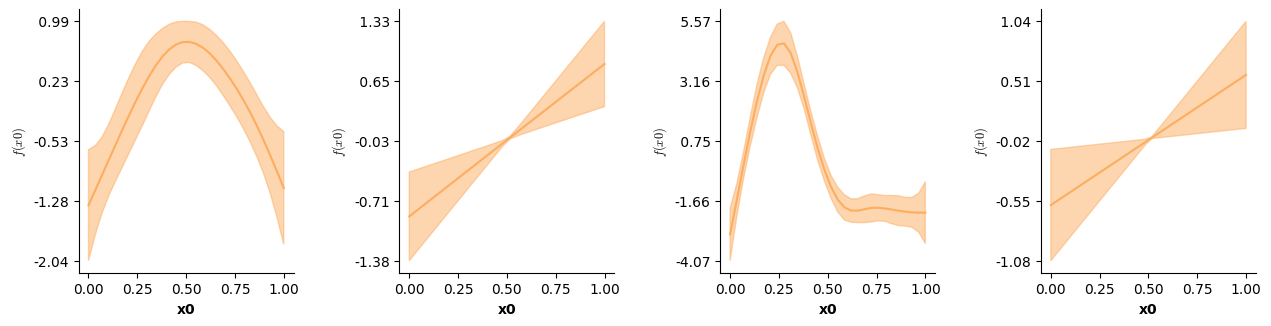

In [83]:
# The plot function can again be used to visualize the estimated effects on the scale of the linear predictor.
fig = plt.figure(figsize=(4*single_size,single_size),layout='constrained')
axs = fig.subplots(1,4,gridspec_kw={"wspace":0.1})
plot(model,dist_par=0,axs=[axs[0]])
plot(model,dist_par=1,axs=[axs[1]])
plot(model,dist_par=2,axs=[axs[2]])
plot(model,dist_par=3,axs=[axs[3]])
plt.show()

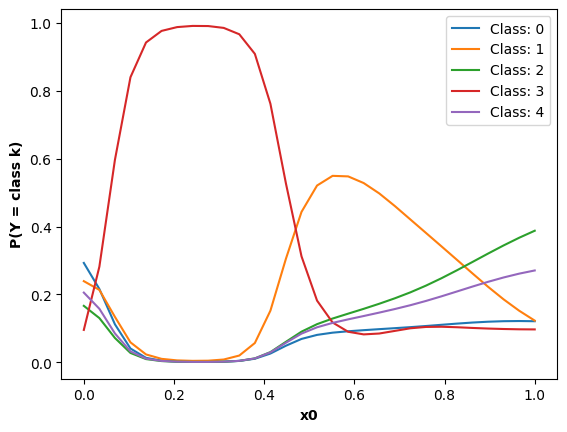

In [84]:
# Visualizing how the probability of Y_i taking on any of the K=5 values is a bit
# more complicated. However, the code below outlines how to achieve this.

# First obtain the K-1 model predictions
pred_dat = pd.DataFrame({"x0":np.linspace(0,1,30)})
mus = []
for k in range(4):

    eta,_,_ = model.predict([0,1],pred_dat,ci=False,par=k)
    mu = family.links[k].fi(eta)
    mus.append(mu)

# These can now be transformed into the K class probabilities (see the MULNOMLSS methods doc-strings for details):
mu_first = np.sum(mus,axis=0) + 1
mus = [mu/mu_first for mu in mus]
mus.insert(0,1/mu_first)

# Now we can plot the K class probabilities as a function of X0:
for k in range(5):
    plt.plot(pred_dat['x0'],mus[k],label=f"Class: {k}")
plt.legend()
plt.xlabel("x0",fontweight='bold')
plt.ylabel("P(Y = class k)",fontweight='bold')
plt.show()

## Advanced topics

In this section we discuss advanced use-cases of `mssm`. We start with an overview of how model selection can be achieved.

### Model selection

`mssm` supports penalty-based model selection (see; Marra & Wood, 2011). In practice, that means the models can penalize entire terms out of the model (they become ~ equal to zero over their covariate(s)). To enable this, provide the ``penalize_null=True`` argument to splines for which this should be enabled.

**Note:** using this with anova-like smooth interactions can result to weird situations, where the marginals are (partially) penalized away but not the (higher-order) partial interaction effects. This can complicate interpretation.

This selection method is particularly efficient for large models, involving many (random) terms. We demonstrate this using the example model considered previously, featuring series-specific random smooth terms:

In [85]:
formula10 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond"), # two-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond",penalize_null=True), # two-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond",penalize_null=True), # three-way interaction
                               fs(["time"],rf="series",nk=20)], # Random non-linear effect of time - one smooth per level of factor series
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:640: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.lhs.variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [86]:
# Fit the model
model10 = GAMM(formula10,Gaussian())
model10.fit(method="Chol",progress_bar=False)
model10.print_smooth_terms()

f(['time'],by=cond): a; edf: 5.819
f(['time'],by=cond): b; edf: 8.164
f(['x'],by=cond): a; edf: 1.489
f(['x'],by=cond): b; edf: 1.581
f(['time', 'x'],by=cond): a; edf: 0.0 *
f(['time', 'x'],by=cond): b; edf: 0.0 *
f(['time'],by=series); edf: 2414.935

2 terms have been effectively penalized to zero and are marked with a '*'


A non-linear two-way interaction between `time` and `x` is not supported for any level of the factor `cond` (since the edf for the two-way interactions are close to 0).

This is also supported by confidence intervals for the two-way interaction: The confidence intervals for the partial two-way interaction effects contain zero for every `x` and `time` combination:

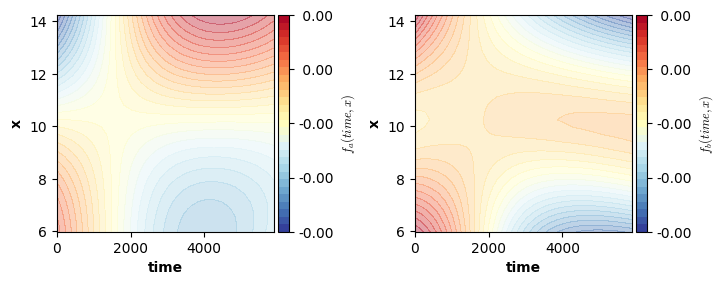

In [87]:
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.3})
plot(model10,which=[4],axs=axs,ci=True)
plt.show()

This suggests that we might get away with dropping the partial two-way interactions of `time` and `x` for both levels of factor `cond`. However, we might want to check first how a model involving only two-way interactions performs against this three-way interaction model. This would be a nested comparison, differing only in a single term we want to check for (the partial three-way interaction). For this we can rely on an approximate GLRT or AIC (see Wood 2017), to check whether the reduction in complexity leads to a drastically worse fit.

**Note, the GLRT should not be combined with penalty-based selection. Hence, model 10 needs to be re-estimated without an extra Kernel penalty.**

In [88]:
formula10 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond"), # two-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # two-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"],by="cond"), # three-way interaction
                               fs(["time"],rf="series",nk=20)], # Random non-linear effect of time - one smooth per level of factor series
                        data=dat)

formula11 = Formula(lhs=lhs("y"), # The dependent variable - here y!
                        terms=[i(), # The intercept, a
                               l(["cond"]), # For cond='b'
                               f(["time"],by="cond"), # two-way interaction between time and cond; one smooth over time per cond level
                               f(["x"],by="cond"), # two-way interaction between x and cond; one smooth over x per cond level
                               f(["time","x"]), # two-way interaction between x and time
                               fs(["time"],rf="series",nk=20)], # Random non-linear effect of time - one smooth per level of factor series
                        data=dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:640: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.lhs.variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [89]:
# Fit the models
model10 = GAMM(formula10,Gaussian())
model10.fit(method="Chol",progress_bar=False)
model10.print_smooth_terms()

model11 = GAMM(formula11,Gaussian())
model11.fit(method="Chol",progress_bar=False)
model11.print_smooth_terms()

f(['time'],by=cond): a; edf: 5.819
f(['time'],by=cond): b; edf: 8.164
f(['x'],by=cond): a; edf: 1.39
f(['x'],by=cond): b; edf: 1.645
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 1.211
f(['time'],by=series); edf: 2414.917
f(['time'],by=cond): a; edf: 5.819
f(['time'],by=cond): b; edf: 8.164
f(['x'],by=cond): a; edf: 1.424
f(['x'],by=cond): b; edf: 1.537
f(['time', 'x']); edf: 1.0
f(['time'],by=series); edf: 2414.927


In [90]:
CDL_res = compare_CDL(model10,model11,perform_GLRT=True)
print(f"Accepting alternative hypothesis that the two-way interaction between time and x actually differs between cond levels? {CDL_res['H1'] == 1}")
print(f"Probability of observing twice the difference in log-likelihood as extreme or more extreme than {CDL_res['test_stat']}\nunder the Null (interaction between time and x does not differ between cond levels): {CDL_res['p']}")
print(f"AIC difference between model 1 and model 2: {CDL_res['aic_diff']}")

Accepting alternative hypothesis that the two-way interaction between time and x actually differs between cond levels? False
Probability of observing twice the difference in log-likelihood as extreme or more extreme than 0.8714115097827744
under the Null (interaction between time and x does not differ between cond levels): 0.9721959947753444
AIC difference between model 1 and model 2: 8.736002301040571


In this case the GLRT would also suggest that the three-way interaction does not contribute significantly to the model. Similarly, the strongly positive AIC difference indicates that model 1, the one including the three-way interaction, does not provide a much better fit. Hence, model 11 (including only the two-way interactions) is probably just as good a model as model 10. Importantly, the GLRT test and AIC criterion are both biased and not necessarily conservative enough - in particular when setting `correct_V=False` (see Wood, Pya, & Säfken; 2016, Smoothing Parameter and Model Selection for General Smooth Models.).

In practice, it should always be set to `True` (the default - note, that there are many strategies available to correct for the bias, `mssm` will automatically select an appropriate one based on the specific model passed to the `compare_CDL` function). See the doc-string for ``compare_CDL`` for more details and consult the references therein. However, even with `correct_V=True` it is generally true that:

**In practice, the test should generally be combined with other evidence (i.e., based on null-penalty information or confidence intervals). p-values close to one's personal alpha level should be considered very carefully.**

Finally, note that the `compare_CDL` function works with `GAMMLSS` and `GSMM` models as well. Below we show another example demonstrating model selection for a `GAMMLSS` model.

In [91]:
# Simulate some data - effect of f0 is zero everywhere!
sim_fit_dat = sim3(n=500,scale=2,c=0,family=Gamma(),seed=21)

# Now fit first model - with f0
sim_fit_formula = Formula(lhs("y"),
                            [i(),f(["x0"]),f(["x1"]),f(["x2"]),f(["x3"])],
                            data=sim_fit_dat,
                            print_warn=False)

sim_fit_formula_sd = Formula(lhs("y"),
                            [i()],
                            data=sim_fit_dat,
                            print_warn=False)

sim_fit_model = GAMMLSS([sim_fit_formula,copy.deepcopy(sim_fit_formula_sd)],family = GAMMALS([LOG(),LOGb(-0.001)]))
sim_fit_model.fit(progress_bar=False)

Now, we know that there is actually no effect of `f(["x0"])` in this data. How can we test for this? One option is to start by looking at the estimated effect and confidence intervals:

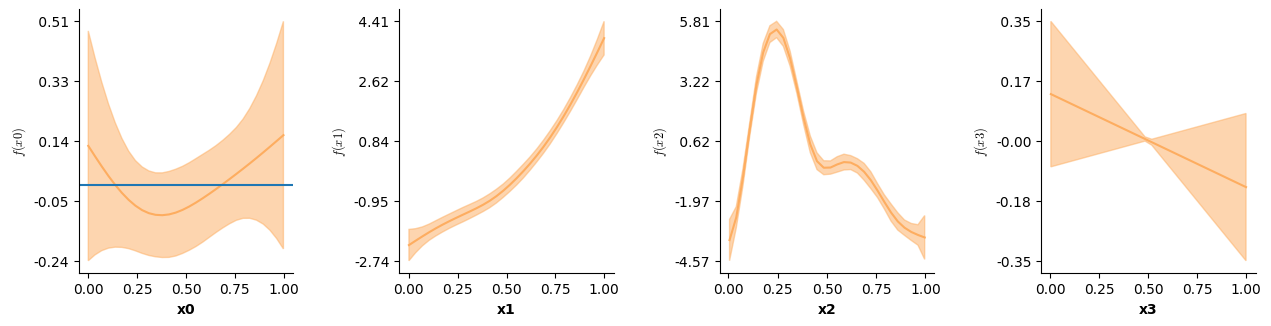

In [92]:
fig = plt.figure(figsize=(4*single_size,single_size),layout='constrained')
axs = fig.subplots(1,4,gridspec_kw={"wspace":0.1})
plot(sim_fit_model,axs=axs)
axs[0].axhline(0)

Now, the CI for `f(["x0"])` clearly includes zero for every value of the covariate - suggesting that there is no effect of "x0". We can also extract a p-value for this via the
`print_smooth_terms` function:

In [93]:
sim_fit_model.print_smooth_terms(p_values=True)


Distribution parameter: 1

f(['x0']); edf: 1.908 chi^2: 2.345 P(Chi^2 > chi^2) = 0.49714
f(['x1']); edf: 3.46 chi^2: 643.143 P(Chi^2 > chi^2) = 0.000e+00 ***
f(['x2']); edf: 8.075 chi^2: 1521.754 P(Chi^2 > chi^2) = 0.000e+00 ***
f(['x3']); edf: 1.0 chi^2: 1.551 P(Chi^2 > chi^2) = 0.21295

Note: p < 0.001: ***, p < 0.01: **, p < 0.05: *, p < 0.1: . p-values are approximate!

Distribution parameter: 2


Note: p < 0.001: ***, p < 0.01: **, p < 0.05: *, p < 0.1: . p-values are approximate!


This also suggests that the effect of `f(["x0"])` is unlikely to be significantly different from zero at any point of the covariate (p = 0.21331). As an alternative, we can again rely on an approximate GLRT or AIC. For this we first need to fit a nested model again, excluding `f(["x0"])`:

In [94]:
# Fit a nested model - without f0:
sim_fit_formula2 = Formula(lhs("y"),
                            [i(),f(["x1"]),f(["x2"]),f(["x3"])],
                            data=sim_fit_dat,
                            print_warn=False)

sim_fit_model2 = GAMMLSS([sim_fit_formula2,copy.deepcopy(sim_fit_formula_sd)],family = GAMMALS([LOG(),LOGb(-0.001)]))
sim_fit_model2.fit(progress_bar=False)

Now we can again use the `compare_CDL` function:

In [95]:
CDL_res = compare_CDL(sim_fit_model,sim_fit_model2,perform_GLRT=True)
print(f"Accepting alternative hypothesis that the f(['x0']) term is not zero everywhere? {CDL_res['H1'] == 1}")
print(f"Probability of observing twice the difference in log-likelihood as extreme or more extreme than {CDL_res['test_stat']}\nunder the Null (the f(['x0']) term is zero everywhere): {CDL_res['p']}")
print(f"AIC difference between model 1 and model 2: {CDL_res['aic_diff']}")

Accepting alternative hypothesis that the f(['x0']) term is not zero everywhere? False
Probability of observing twice the difference in log-likelihood as extreme or more extreme than 2.4938902067060553
under the Null (the f(['x0']) term is zero everywhere): 0.48745474003985256
AIC difference between model 1 and model 2: 2.6953749094946033


Again, neither the GLRT nor the AIC score of ~ 2.6351 suggest that we need to include `f(["x0"])`. Hence, the second model excluding it should be preferred.

### Very big random effect models

`mssm` can approximate the computations involved in determining the smoothness penalty for **trial/series-level** random smooth terms for Gaussian additive models. This can drastically speed up the time it takes to fit the model. Below, we demonstrate this by re-estimating model 9. Note, that the approximate model might differ slightly in terms of edf and fitted effects from the exact model.

Approximating computations requires specifying a discretization dictionary for each random smooth term for which computations should be approximate. The dictionary must implement **this structure**: `{"no_disc":[str],"excl":[str],"split_by":[str],"restarts":int}`:

- `no_disc` should usually be set to an empty list, and should in general only contain names of
continuous variables included in the formula. Any variable included in this list will not be discretized in advance. This can improve performance if continuous variables are included with less than 10 unique values. However, it also slows down the clustering that is performed as part of the approximation strategy.

- Similarly, `excl` specifies any continuous variables that should be **excluded** for clustering - this can speed up clustering quite a bit but the resulting model might differ more from the exact one because variables are essentially ignored for the computation. Hence, this should only be set to an non-empty list if you really know what you are doing.

- `split_by` should generally be set to a list containing all categorical variables present in the formula.

- `restarts` indicates the number of times to re-produce the clustering (should be set to at least 40). Increasing this number usually leads to better results - but the upfront computation cost is increased.

In [96]:
# Approximating computations requires specifying a discretization dictionary.
discretize = {"no_disc":[],"excl":[],"split_by":["cond"],"restarts":40, "seed":20}

formula12 = Formula(lhs=lhs("y"),
                        terms=[i(),
                               l(["cond"]),
                               f(["time"],by="cond"),
                               f(["x"],by="cond"),
                               f(["time","x"],by="cond"),
                               fs(["time"],rf="series",nk=20,approx_deriv=discretize)],
                        data=dat,
                        print_warn=False,
                        series_id="series") # When approximating the computations for a random smooth, the series identifier column needs to be specified!

In [97]:
# Fit the model
model12 = GAMM(formula12,Gaussian())
model12.fit(method="Chol",progress_bar=False)
model12.print_smooth_terms()

f(['time'],by=cond): a; edf: 5.824
f(['time'],by=cond): b; edf: 8.164
f(['x'],by=cond): a; edf: 1.389
f(['x'],by=cond): b; edf: 1.645
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 1.21
f(['time'],by=series); edf: 2432.283


### Very big random effect models + MANY observations

In case a Gaussian model needs to be estimated with a big random effect structure and from more than 3-4 million observations, ``mssm`` can follow the strategy described in "Generalized additive models for large data sets" (Wood, Goude, and Shaw; 2015) to only build the products involving the model matrix once and to never accumulate the entire model matrix. This requires that the data-set is separated into multiple smaller .csv files (see the code below for an example split of the sim_dat.csv) - which ``mssm`` will process in parallel to accumulate the products involving the model matrix.

At every iteration the model predictions need to be obtained which requires the product of a row-block of the model matrix and the current estimate of the coefficient vector. ``mssm`` either needs to re-compute the row-block for each prediction or can rely on caching to read it from a drive. For extremely big models (> 20 million observations) the latter can be substantially faster (depending on the system's hardware). By default caching is disabled. To enable it the ``mssm.src.python.gamm_solvers.SHOULD_CACHE`` variable should be set to True. The ``mssm.src.python.gamm_solvers.CACHE_DIR`` variable determines the relative location (default "./.db") of the cache directory. The directory will be deleted after estimation (if running the model fails, the directory might persist - ``mssm`` will require the user to manually delete the directory in that case).

Below we re-estimate model 10 (with the extra Kernel penalties) using this iterative building strategy. In terms of fit and edf both models should be viertually identical.

In [98]:
# Note: Categorical variables need to be stored in a way that makes it obvious to pandas that they are not numeric.
# The code below shows how the data for this example were split

if False:
    for cond in np.unique(dat["cond"]):
        cond_dat = dat.loc[dat["cond"] == cond,:]
        cond_dat.loc[:,"series"] = "series_" + cond_dat["series"].astype(str)
        cond_dat.loc[:,"sub"] = "sub_" + cond_dat["sub"].astype(str)
            
        cond_dat.to_csv(f"./data/GAMM/sim_dat_cond_{cond}.csv",index=False,header=True)

In [99]:
# Now we just collect the paths to the split files and pass those to the formula.
file_paths = [f'https://raw.githubusercontent.com/JoKra1/mssmViz/main/data/GAMM/sim_dat_cond_{cond}.csv' for cond in ["a","b"]]

In [100]:
import mssm as mssm

# Disable caching (default)
mssm.src.python.gamm_solvers.SHOULD_CACHE = False

# Ensure ordering matches the one enforced automatically for model11.
codebook = {'cond':{'a': 0, 'b': 1}}

formula13 = Formula(lhs=lhs("y"),
                        terms=[i(),
                               l(["cond"]),
                               f(["time"],by="cond"),
                               f(["x"],by="cond",penalize_null=True),
                               f(["time","x"],by="cond",penalize_null=True),
                               fs(["time"],rf="series",nk=20)],
                        data=None, # No data frame!
                        file_paths=file_paths, # Just a list with paths to files.
                        print_warn=False,
                        keep_cov=False, # Re-read and encode all data from file at every iteration - further reducing memory footprint, but can slow down if reading takes long
                        codebook=codebook,
                        file_loading_nc = 10) # Set number of cores used for building X.TX in parallel!

In [101]:
# Fit the model
model13 = GAMM(formula13,Gaussian())
model13.fit(method="Chol",progress_bar=False)
model13.print_smooth_terms()

f(['time'],by=cond): a; edf: 5.819
f(['time'],by=cond): b; edf: 8.164
f(['x'],by=cond): a; edf: 1.489
f(['x'],by=cond): b; edf: 1.581
f(['time', 'x'],by=cond): a; edf: 0.0 *
f(['time', 'x'],by=cond): b; edf: 0.0 *
f(['time'],by=series); edf: 2414.935

2 terms have been effectively penalized to zero and are marked with a '*'


You can also combine the iterative model building with the derivative approximation strategy. Note, that this only works with ``keep_cov=True``:

In [102]:
discretize = {"no_disc":[],"excl":[],"split_by":["cond"],"restarts":40, "seed":20}

formula13d = Formula(lhs=lhs("y"),
                        terms=[i(),
                               l(["cond"]),
                               f(["time"],by="cond"),
                               f(["x"],by="cond",penalize_null=True),
                               f(["time","x"],by="cond",penalize_null=True),
                               fs(["time"],rf="series",nk=20,approx_deriv=discretize)],
                        data=None, # Still no data frame!
                        file_paths=file_paths, # Still just a list with paths to files.
                        print_warn=False,
                        keep_cov=True, # Cannot re-read and encode all data from file at every iteration when also relying on the deriv. approx. strategy
                        codebook=codebook,
                        file_loading_nc = 10,
                        series_id="series") # When approximating the computations for a random smooth, the series identifier column needs to be specified!

In [103]:
# Fit the model
model13d = GAMM(formula13d,Gaussian())
model13d.fit(method="Chol",progress_bar=False)
model13d.print_smooth_terms()

f(['time'],by=cond): a; edf: 5.811
f(['time'],by=cond): b; edf: 8.165
f(['x'],by=cond): a; edf: 1.491
f(['x'],by=cond): b; edf: 1.581
f(['time', 'x'],by=cond): a; edf: 0.0 *
f(['time', 'x'],by=cond): b; edf: 0.0 *
f(['time'],by=series); edf: 2384.192

2 terms have been effectively penalized to zero and are marked with a '*'


### ar1 Models of the residuals

Fitting series-specific random smooth terms will get expensive the more series collected - even using the tricks discussed above. In addition, including this many coefficients is not really justified for Generalized models (see Wood et al., 2015 for a discussion). An alternative is to specify an "ar1" model of the residuals - capturing dependencies between residuals based on a first-order auto-regressive model (see Wood et al., 2015 and Wood, 2017 for an introduction).

Below, we show how to set up an "ar1" model in `mssm`. To understand the need for an "ar1" model, consider model 7d. This model was already quite complex - including subject-specific random smooth terms, separately per level of factor "cond":

In [104]:
model7d.print_smooth_terms()

f(['time'],by=cond): a; edf: 6.894
f(['time'],by=cond): b; edf: 8.523
f(['x'],by=cond): a; edf: 1.069
f(['x'],by=cond): b; edf: 1.069
f(['time', 'x'],by=cond): a; edf: 1.0
f(['time', 'x'],by=cond): b; edf: 1.0
f(['time'],by=sub_cond): a; edf: 87.001
f(['time'],by=sub_cond): b; edf: 134.415


Still, the residuals clearly show remaining dependencies that the model does not account for:

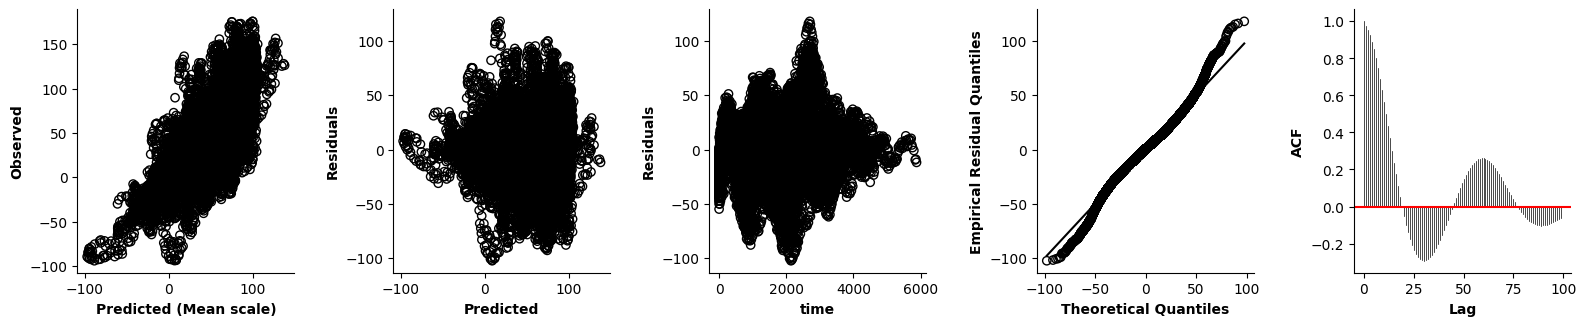

In [105]:
fig = plt.figure(figsize=(5*single_size,single_size),layout='constrained')
axs = fig.subplots(1,5,gridspec_kw={"wspace":0.1})
plot_val(model7d,resid_type="Pearson",pred_viz=["time"],axs=axs)

Now, we can try and use an "ar1" model to account for these dependencies. **Note**, that we should set up the "ar1" model in such a way, that the model restarts with every collected time-series and does not treat the entire residual series as one long time-series. To achieve this, we need to specify the `series_id` argument, when setting up the formula of the model (see the code examples of the `Formula` class for more details):

In [106]:
# Now we can specify the formula:
formula7d_ar = Formula(lhs=lhs("y"),
                        terms=[i(),
                               l(["cond"]),
                               f(["time"],by="cond"),
                               f(["x"],by="cond"),
                               f(["time","x"],by="cond"),
                               fs(["time"],rf="sub_cond",by_subgroup=["cond","a"]),
                               fs(["time"],rf="sub_cond",by_subgroup=["cond","b"])],
                        data=dat,
                        series_id="series") # Setting series_id to a string instead of None means the 'ar1' model will restart per series!

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:640: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.lhs.variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


Now, specifying the model works just as before. The difference, is that we now need to set the `rho` argument of the `model.fit` method. `rho` has to be set to the weight of the auto-regressive parameter. A good starting point is to pick the absolute value of the auto-correlation at lag 1 of model 7d, which is approximately 0.98 here:

In [107]:
model7d_ar = GAMM(formula7d_ar,Gaussian())
model7d_ar.fit(rho=0.97,progress_bar=False)

Now, we can compare the "ar1-corrected" residuals (see Wood, 2017) of this model, to the residuals of the previous model:

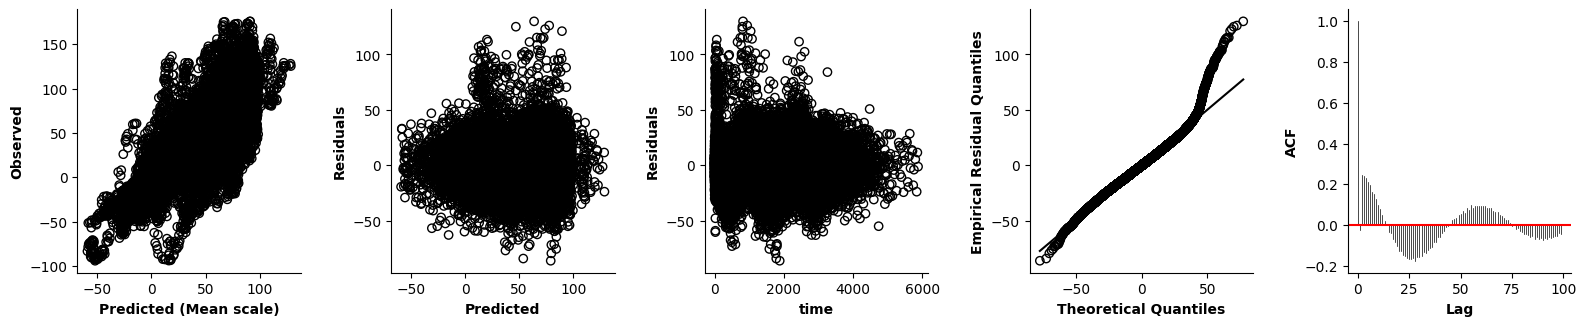

In [108]:
fig = plt.figure(figsize=(5*single_size,single_size),layout='constrained')
axs = fig.subplots(1,5,gridspec_kw={"wspace":0.1})
plot_val(model7d_ar,resid_type="ar1",pred_viz=["time"],axs=axs) # set resid_type to "ar1"!

The model's still not perfect - but the acf plot, the predicted vs. residuals plot, and the time vs. residuals plot are all far less concerning (note how the "stringing" in the last two disappeared almost completely). To improve the model further, we might want to include random intercepts per series. Additionally, we could try different values for `rho`. We could even select `rho` formally - by picking the model with the highest ``reml`` score (e.g., Wood et al., 2015). If you want to set up such a grid-search over different values of `rho`, the `reml` score is available via `model.get_reml()`.

#### ar1 Model for Generalized Models

Like the `bam` function in `mgcv`, the `GAMM` class in `mssm` also allows to include an "ar1" model for generalized models - the "ar1" model is then applied to the "working residuals" of the linearized model (see Wood, 2017). Below we show an example for a Gamma model:

In [109]:
# We simulate some data including a random smooth - but then dont include it in the model:
sim_dat = sim11(5000,2,c=0,seed=20,family=Gamma(),n_ranef=20,binom_offset = 0)

sim_dat = sim_dat.sort_values(['x4'], ascending=[True])

sim_formula = Formula(lhs("y"),
                      [i(),f(["x0"]),f(["x1"]),f(["x2"]),f(["x3"])],
                      data=sim_dat,
                      series_id="x4") # Can already specify this.

gamma_model2 = GAMM(sim_formula,Gamma())
gamma_model2.fit(progress_bar=False)

Both the plot of the deviance residuals and the plot of the pearson residuals shows some auto-correlation. Let's try and improve this by including an "ar1" model:

(-0.2, 1.0)

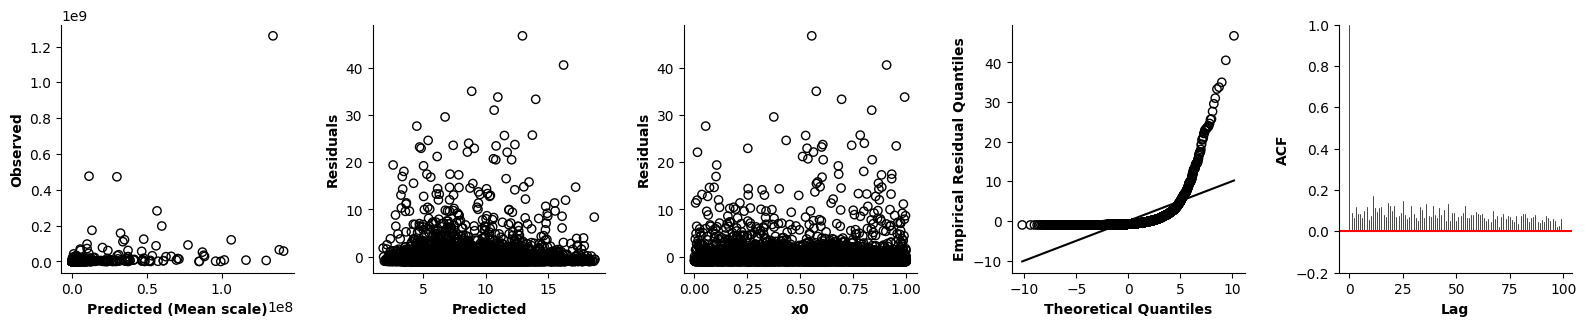

In [110]:
fig = plt.figure(figsize=(5*single_size,single_size),layout='constrained')
axs = fig.subplots(1,5,gridspec_kw={"wspace":0.1})
plot_val(gamma_model2,pred_viz=["x0"],resid_type="Pearson",axs=axs)
axs[-1].set_ylim([-0.2,1])

In [111]:
gamma_model2.fit(rho=0.25,restart=True,progress_bar=False)

The model slightly improves when including an "ar1" model:

(-0.2, 1.0)

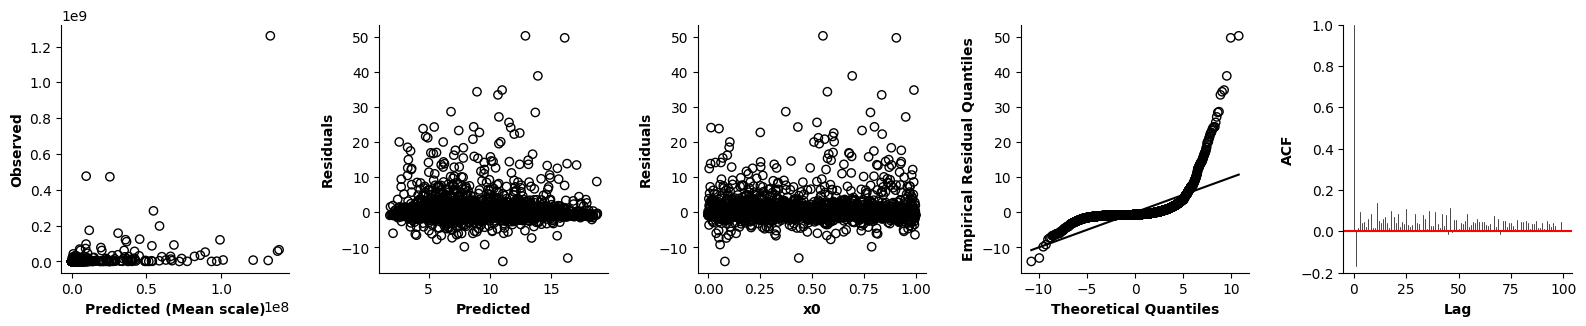

In [112]:
fig = plt.figure(figsize=(5*single_size,single_size),layout='constrained')
axs = fig.subplots(1,5,gridspec_kw={"wspace":0.1})
plot_val(gamma_model2,pred_viz=["x0"],resid_type="ar1",axs=axs)
axs[-1].set_ylim([-0.2,1])

We could try and include random intercepts per level of "x4" to further improve the model.

### Posterior Simulation & Whole-interval CIs

In the section on model selection we briefly dicussed CIs, and pointed out that they offer an additional tool to check whether a function should be included in the model or not. Importantly, the CIs visualized so far are point-wise CIs, but to determine whether a function should be included in the model at all, whole-function CIs are more appropriate. Point-wise CIs include the true function on average at 95% of the values evaluated - but that rate might be higher or lower for some combination of predictor values over which the interval is evaluated (i.e., the coverage is truly achieved "on average"; see Wood, 2017). Whole-function CIs on the other hand are modified to encapsulate the true function at every evaluated predictor combination with a certain probability (see Wood, 2017 but also Simpson, 2016 for more details) - i.e., they ensure that the entire true function falls within the CI boundaries with 95% certainty.

The difference can be visualized best by simulating from the conditional posterior distribution of a GAM(M). Wood (2017) shows that the latter is approximately $\beta | \lambda,y \sim N(\hat{\beta},\mathbf{V})$. Where $\mathbf{V}$ is the inverse of the ngeative Hessian of the penalized likelihood. By defining model-matrix $\hat{\mathbf{X}}$ to only contain non-zero entries in the columns related to some function of interest $f$, we can use this result to simulate replications of $f$.

Below we sample from the posterior of `f["time"]` for level "a" of factor "cond" from model 10:

In [113]:
# Set up some new data for prediction
tr = np.linspace(0,4000,30)

pred_dat = pd.DataFrame({"time":tr,
                        "x":[-1 for _ in range(len(tr))],
                        "cond":["a" for _ in range(len(tr))],
                        "series":[0 for _ in range(len(tr))]})

_,pred_mat,_ = model10.predict([2],pred_dat)

In [114]:
# `use_post` identifies only coefficients related to f(time) - and only for condition a
use_post = pred_mat.sum(axis=0) != 0
use_post = np.arange(0,pred_mat.shape[1])[use_post]
use_post

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])

In [115]:
# Now we can sample new realizations of f(time) from the conditional posterior
# By default all plotting functions will draw 10.000 samples from the posterior so we specify this for the manual sampling below.
post = model10.sample_post(10000,use_post,seed=2000)
post_f = pred_mat[:,use_post] @ post

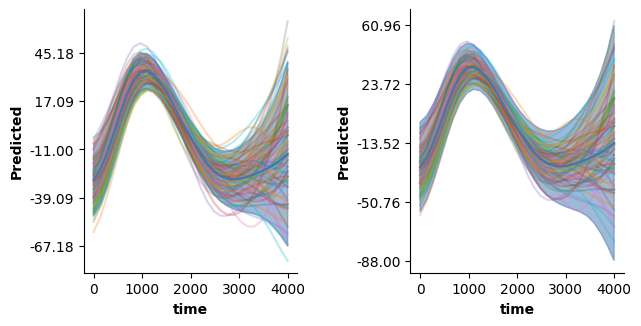

In [116]:
# And plot the replications against a point-wise and a whole-function CI
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.1})

for sim in range(100):
    axs[0].plot(pred_dat["time"],post_f[:,sim],alpha=0.3)

plot_fitted(pred_dat,["time"],model10,[2],ax=axs[0],plot_exist=False,col=0.1)

for sim in range(100):
    axs[1].plot(pred_dat["time"],post_f[:,sim],alpha=0.3)

# This time, we set the whole-interval argument to `True`.
plot_fitted(pred_dat,["time"],model10,[2],ax=axs[1],whole_interval=True,plot_exist=False,col=0.1)

plt.show()

Evidently, while the point-wise CI covers the simulated replications consistently over some time values, there are quite a few curves that do not fall within the CI boundaries *when considering the entire time range*. For the whole-function CI most replicate functions are *completely* encapsulated.

To clarify, the point-wise CI is **not** performing poorly here! In fact, the check below confirms that - *on average over time* - it contains simulated replicates in 95% across simulations. However, only in around 75% of simulations does it contain the function over the whole time range - but it was simply not designed to achieve this!

In [117]:
# Get the boundaries shown in the left plot and check them against each replicate function
# drawn from the posterior.
pred,pred_mat,b = model10.predict([2],pred_dat,whole_interval=False,seed=2000,ci=True)

avg = []
full_cov = 0
for pi in range(post_f.shape[1]):
    IN_CI = ((pred + b) > post_f[:,pi]) & ((pred - b) < post_f[:,pi])
    if not False in np.unique(IN_CI):
        full_cov += 1

    avg.append(len(pred[IN_CI])/len(pred))

full_cov/=post_f.shape[1]
print(np.mean(avg))
print(full_cov)

0.95057
0.7417


We can now run the same check for the whole-function CI. Note that for the check a different seed is used (otherwise coverage would be exactly 95%). Nevertheless, the whole-function CI covers the entire replicate in approximately 95% of simulations. In terms of average coverage it over-performs (naturally) - achieving a point-wise coverage of almost 99%. This is only logical, considering that the interval is simply expanded - relative to the point-wise CI (see Wood et al., 2016).

In [118]:
# Get the boundaries shown in the right plot and check them against each replicate function
# drawn from the posterior.
pred,pred_mat,b = model10.predict([2],pred_dat,whole_interval=True,seed=1500,ci=True)

avg = []
full_cov = 0
for pi in range(post_f.shape[1]):
    IN_CI = ((pred + b) > post_f[:,pi]) & ((pred - b) < post_f[:,pi])
    if not False in np.unique(IN_CI):
        full_cov += 1

    avg.append(len(pred[IN_CI])/len(pred))

full_cov/=post_f.shape[1]
print(np.mean(avg))
print(full_cov)

0.9933
0.9533


This quick comparison highlights, that if you want to check whether a smooth has *any* effect, i.e., whether it should be included in the model, whole-function CIs are much more appropriate, simply because they test this more explicitly. That is: if the whole-function CI for a smooth contains zero at every evaluated predictor combination, it is probably safe to assume that the effect can be dropped from the model.

#### Posterior Simulation & Whole-interval CIs for GAMMLSS and GSMM models

The api to sample from the posterior of a GAMMLSS or GSMM model is very similar - the only difference is that `model.sample_post` works for a specified parameter of the log-likelihood/response variables. This is illustrated below. We consider the complex GAMMLSS example we introduced above:

In [119]:
gaumlss_model2.print_smooth_terms()


Distribution parameter: 1

f(['x0']); edf: 4.146
f(['x1']); edf: 5.709
f(['x0'],by=x4); edf: 110.674

Distribution parameter: 2

f(['x2']); edf: 7.339
f(['x3']); edf: 1.001


In this model, two parameters of the log-likelihood (the mean and scale parameter) were specified as additive models - both of which involve smooth functions. Now let's say we want to sample the posterior of `f(["x0"])` included in the model of the mean. To achieve this, we largely proceed as we did for the GAMM model. We start with setting up new data.

In [120]:
# Set up some new data for prediction
pred_dat = pd.DataFrame({"x0":np.linspace(0,1,30),
                         "x1":np.linspace(0,1,30),
                         "x4":[gaumlss_model2.formulas[0].coding_factors["x4"][0] for _ in range(30)]})

_,pred_mat,_ = gaumlss_model2.predict([1],pred_dat,par=0)

Note, that we only had to include values in `pred_dat` for variables associated with the first formula. Now we can again figure out for which coefficients we want to sample the posterior:

In [121]:
# `use_post` identifies only coefficients related to f(x0)
use_post = pred_mat.sum(axis=0) != 0
use_post = np.arange(0,pred_mat.shape[1])[use_post]
use_post

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

Now we are ready to sample the posterior:

In [122]:
# Now we can sample new realizations of f(x0) from the conditional posterior
# By default all plotting functions will draw 10.000 samples from the posterior so we specify this for the manual sampling below.
post = gaumlss_model2.sample_post(10000,use_post,seed=2000)
post_f = pred_mat[:,use_post] @ post

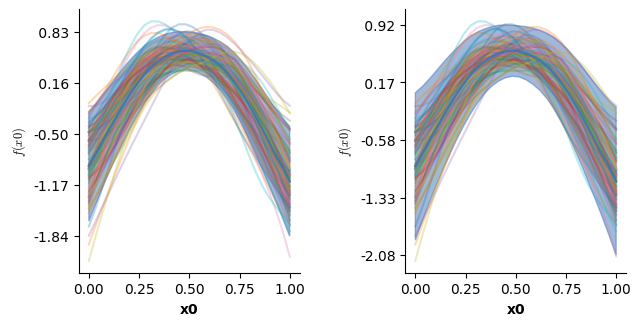

In [123]:
# And plot the replications against a point-wise and a whole-function CI
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.1})

for sim in range(100):
    axs[0].plot(pred_dat["x1"],post_f[:,sim],alpha=0.3)

plot(gaumlss_model2,which=[1],axs=[axs[0]],prov_cols=0.1)

for sim in range(100):
    axs[1].plot(pred_dat["x1"],post_f[:,sim],alpha=0.3)

# This time, we set the whole-interval argument to `True`.
plot(gaumlss_model2,which=[1],axs=[axs[1]],whole_interval=True,prov_cols=0.1)

plt.show()

All in all, this was not that different from sampling the posterior for a GAMM, right? Right! Now, let's look at sampling the posterior of `f["x2"]` in the model of the scale paramter. The steps are the same, the important thing is that we set `par=1` when calling `gaumlss_model2.predict`. We still set `use_terms=[1]` since we want the second term (first smooth term) in the formula/model of the scale parameter:

In [124]:
# Set up some new data for prediction - this time for scale parameter
pred_dat = pd.DataFrame({"x2":np.linspace(0,1,30),
                         "x3":np.linspace(0,1,30)})

_,pred_mat,_ = gaumlss_model2.predict([1],pred_dat,par=1)

In [125]:
# `use_post` identifies only coefficients related to f(x2) in the model of the scale parameter
use_post = pred_mat.sum(axis=0) != 0
use_post = np.arange(0,pred_mat.shape[1])[use_post]
use_post

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

Now, the step to figure out which coefficients we need might be a bit confusing - after all the indices are the same we got when sampling from the model of the mean. However, this is intended - as clarified by looking what it says under `use_post` in the doc string of the `.sample_post` function:

In [126]:
help(gaumlss_model.sample_post)

Help on method sample_post in module mssm.models:

sample_post(
    n_ps: int,
    use_post: list[int] | None = None,
    deviations: bool = False,
    seed: int | None = None,
    par: int = 0
) -> numpy.ndarray method of mssm.models.GAMMLSS instance
    Obtain ``n_ps`` samples from posterior :math:`[\boldsymbol{\beta}_m - \hat{\boldsymbol{\beta}}_m] | \mathbf{y},\boldsymbol{\lambda} \sim N(0,\mathbf{V})`,
    where :math:`\mathbf{V}=[-\mathbf{H} + \mathbf{S}_{\lambda}]^{-1}` (see Wood et al., 2016; Wood 2017, section 6.10), :math:`\boldsymbol{\beta}_m` is the set of
    coefficients in the model of parameter :math:`m` of the distribution (see argument ``par``), and :math:`\mathbf{H}` is the hessian of
    the log-likelihood (Wood et al., 2016;). To obtain samples for :math:`\boldsymbol{\beta}`, set ``deviations`` to false.

    see :func:`sample_MVN` for more details.

    Examples::

        from mssm.models import *
        from mssmViz.sim import *
        from mssmViz.plot import

So `.sample_post` expects indices with respect to the number of coefficients in the chosen formula/model (i.e., indicated via `par`). Now, the second formula starts with an intercept term, just like the first one. Hence, the first coefficient associated with `f(["x2"])` in the model of the scale parameter makes up the second column of the model matrix - corresponding to index 1. Thus, the returned indices are correct and we can proceed with sampling the posterior. Importantly, we again have to specify the `par` parameter and set it to 1:

**Note**: if you set the same seed when sampling the posterior for different parameters, exactly the same coefficient samples will be generated for all individual parameters - so it will be like sampling the posterior of all parameters simultaneously.

In [127]:
# Now we can sample new realizations of f(x2) from the conditional posterior
post = gaumlss_model2.sample_post(10000,use_post,seed=2000,par=1)
post_f = pred_mat[:,use_post] @ post

Finally, we can plot - again taking care to specify `dist_par=1` wherever needed:

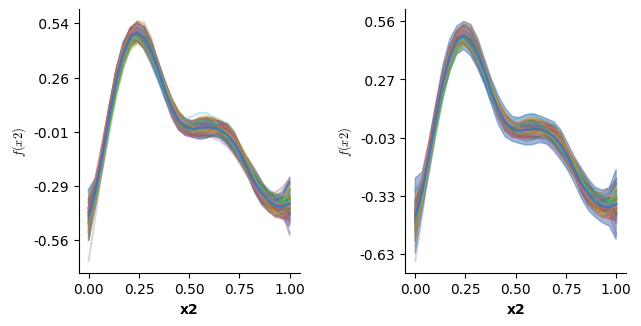

In [128]:
# And plot the replications against a point-wise and a whole-function CI
fig = plt.figure(figsize=(2*single_size,single_size),layout='constrained')
axs = fig.subplots(1,2,gridspec_kw={"wspace":0.1})

for sim in range(100):
    axs[0].plot(pred_dat["x2"],post_f[:,sim],alpha=0.3)

plot(gaumlss_model2,which=[1],axs=[axs[0]],prov_cols=0.1,dist_par=1)

for sim in range(100):
    axs[1].plot(pred_dat["x2"],post_f[:,sim],alpha=0.3)

# This time, we set the whole-interval argument to `True`.
plot(gaumlss_model2,which=[1],axs=[axs[1]],whole_interval=True,prov_cols=0.1,dist_par=1)

plt.show()

### The `GSMM` class in `mssm`

The `GSMM` class supports the most generic smooth models, as defined by Wood, Pya, and Säfken (2016; see also Krause et al., submitted). Essentially, it allows to estimate any model with a regular likelihood - the parameters of which can be specified as smooth models. An intriguing aspect of the `GSMM` class, is that it can rely on the `L-qEFS` algorithm (Krause et al., submitted) to estimate these models. When relying on the `L-qEFS` algorithm, `mssm` only requires researchers to code up the log-likelihood of the model they want to estimate. In this section we show how this could look like. We work with a simple example - and just imagine for now that we completely forgot how to estimate a Gaussian model of location, scale and shape.

The first thing we need to do to estimate a `GSMM` is to implement the `GSMMFamily` class. We can again look at the `help` function to get an idea of what that entails:

In [129]:
help(GSMMFamily)

Help on class GSMMFamily in module mssm.src.python.exp_fam:

class GSMMFamily(builtins.object)
 |  GSMMFamily(pars: int, links: list[mssm.src.python.exp_fam.Link], *llkargs) -> None
 |
 |  Base-class for General Smooth "families" as discussed by Wood, Pya, & Säfken (2016). For estimation of :class:`mssm.models.GSMM` models via
 |  ``L-qEFS`` (Krause et al., submitted) it is sufficient to implement :func:`llk`. :func:`gradient` and :func:`hessian` can then simply return ``None``. For exact estimation via
 |  Newton's method, the latter two functions need to be implemented and have to return the gradient and hessian at the current coefficient estimate
 |  respectively.
 |
 |  Additional parameters needed for likelihood, gradient, or hessian evaluation can be passed along via the ``llkargs``. They are then made available in ``self.llkargs``.
 |
 |  References:
 |   - Wood, Pya, & Säfken (2016). Smoothing Parameter and Model Selection for General Smooth Models.
 |   - Nocedal & Wright (200

As mentioned, this again states that we only need to implement the `GSMMFamily.llk` method if we want to rely on the `L-qEFS` update. Let's take a closer look at what that function looks like:

In [130]:
help(GSMMFamily.llk)

Help on function llk in module mssm.src.python.exp_fam:

llk(
    self,
    coef: numpy.ndarray,
    coef_split_idx: list[int],
    ys: list[numpy.ndarray | None],
    Xs: list[scipy.sparse._csc.csc_array | None]
) -> float
    log-probability of data under given model.

    References:
     - Wood, Pya, & Säfken (2016). Smoothing Parameter and Model Selection for General Smooth Models.
     - Wood, S. N. (2017). Generalized Additive Models: An Introduction with R, Second Edition (2nd ed.).
     - Krause et al. (submitted). The Mixed-Sparse-Smooth-Model Toolbox (MSSM): Efficient Estimation and Selection of Large Multi-Level Statistical Models. https://doi.org/10.48550/arXiv.2506.13132

    :param coef: The current coefficient estimate (as np.array of shape (-1,1) - so it must not be flattened!).
    :type coef: np.ndarray
    :param coef_split_idx: A list used to split (via :func:`np.split`) the ``coef`` into the sub-sets associated with each paramter of the llk.
    :type coef_split_i

Ok, this tells us what the `.llk` function expects in terms of parameters, and what it should return - the log-likelihood of the model as a float. Now we can go ahead and implement the `GSMMFamily`. We need to implement the following:

- The `.__init__` method, which the `help` function tells us needs to receive arguments `pars` (the number of parameters of the log-likelihood, here 2) and `links` (the link functions to be used by the models of the parameters). We could also pass along additional arguments, but we don't need those in this simple example.
- The `llk` method, which needs to accept arguments `coef` (a np.array holding the coefficients), `coef_split_idx` (a list with indices to split `coef` into parameter specific vectors), `ys` (a list holding the vectors of observations - in this example that is a single one), and `Xs` (a list holding the model matrices of all parameters)

Below, we show how this implementation could look like:

In [131]:
class GSMMGAUMLS(GSMMFamily):
    # Implementation of the ``GSMMFamily`` class to estimate a Gaussian GAMLSS via the general smooth code and
    # the L-qEFS update by Krause et al. (in preparation).
    
    # We set up the constructor and then just call the constructor of the `GSMMFamily` class we inherit from
    def __init__(self, links:list[Link]) -> None:
        super().__init__(2, links)
    
    def llk(self, coef: np.ndarray,coef_split_idx: list[int],ys: list[np.ndarray],Xs: list[scp.sparse._csc.csc_array]):
        # Likelihood for a Gaussian GAM(LSS) - implemented so
        # that the model can be estimated using the general smooth code.

        # There is only one vector of observations - but Xs holds two model matrices!!
        y = ys[0]

        # Now we can split the coefficients into a vector per parameter
        split_coef = np.split(coef,coef_split_idx)

        # And then define the linear predictors for both parameters
        eta_mu = Xs[0]@split_coef[0]
        eta_sd = Xs[1]@split_coef[1]
        
        # And convert them into the actual predicted parameters
        mu_mu = self.links[0].fi(eta_mu)
        mu_sd = self.links[1].fi(eta_sd)

        # Now we can just evaluate the log-likelihood of len(y) independent Gaussians:
        llk = np.sum(scp.stats.norm.logpdf(y,loc=mu_mu,scale=mu_sd))
        return llk

Now we can simulate some data (we will use the complex GAMMLSS example we discussed earlier) and then estimate the model we estimated previously via the `GAMMLSS` class, using the `GSMM` class:

In [132]:
sim_dat = sim12(5000,c=0,seed=0,family=GAUMLSS([Identity(),LOG()]),n_ranef=20)

# We again need to model the mean: \mu_i = \alpha + f(x0) + f(x1) + f_{x4}(x0)
sim_formula_m = Formula(lhs("y"),
                    [i(),f(["x0"]),f(["x1"]),fs(["x0"],rf="x4")],
                    data=sim_dat)

# and the standard deviation as well: log(\sigma_i) = \alpha + f(x2) + f(x3)
sim_formula_sd = Formula(lhs("y"),
                    [i(),f(["x2"]),f(["x3"])],
                    data=sim_dat)

gsmm1 = GSMM([sim_formula_m,sim_formula_sd],GSMMGAUMLS([Identity(),LOGb(-0.0001)]))

Specfiying a `GSMM` model thus is very similar to specfiying a `GAMMLSS` model. Now we can fit the model using the `L-qEFS` update. For this, we only need to pass a single argument to the `fit` method of the `GSMM` model:

In [133]:
gsmm1.fit(method='qEFS',progress_bar=False)

It takes longer to fit this model - mainly because it has to approximate the gradient of the log-likelihood. Importantly, despite only having access to the log-likelihood the model still produces estimates comparable to those obtained from the `GAMMLSS` class - which relies on both gradient and Hessian of the log-likelihood during estimation:

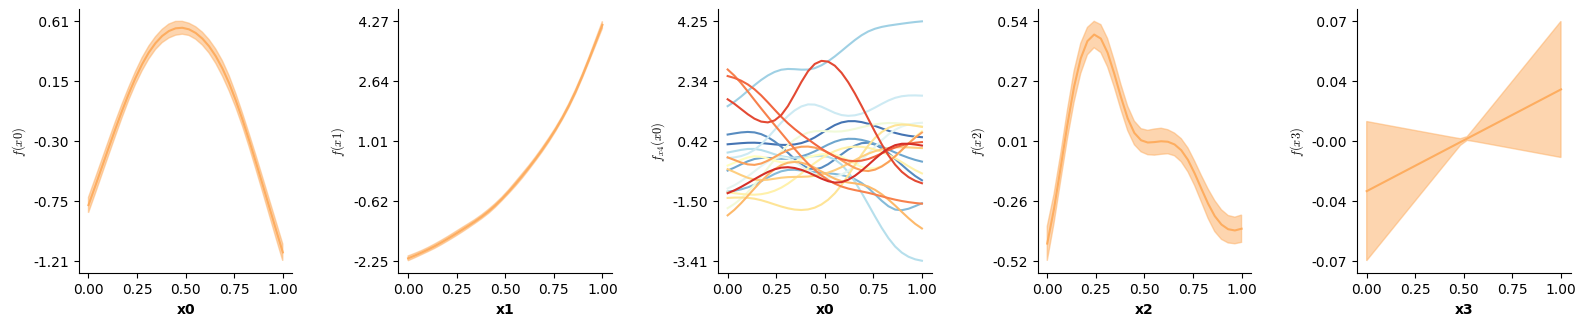

In [134]:
fig = plt.figure(figsize=(5*single_size,single_size),layout='constrained')
axs = fig.subplots(1,5,gridspec_kw={"wspace":0.1})
plot(gsmm1,axs=axs[:3])
plot(gsmm1,axs=axs[3:],dist_par=1)

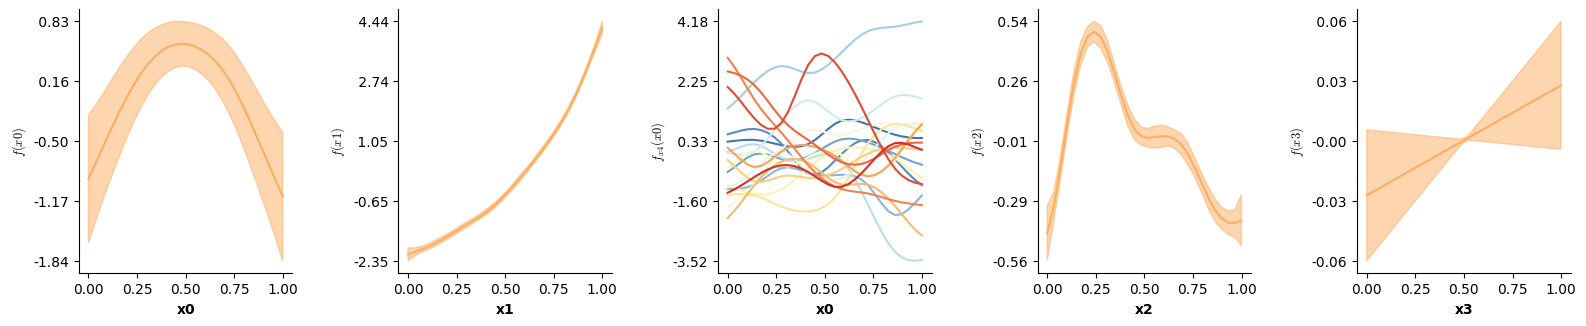

In [135]:
# For comparison: the GAMMLSS estimates
fig = plt.figure(figsize=(5*single_size,single_size),layout='constrained')
axs = fig.subplots(1,5,gridspec_kw={"wspace":0.1})
plot(gaumlss_model2,axs=axs[:3])
plot(gaumlss_model2,axs=axs[3:],dist_par=1)

**Important**: while the `L-qEFS` update provides quantities that can be used to obtain confidence intervals (see the plot above), these are unlikely to have the same good coverage achieved by more theoretically complex algorithms (i.e., Newton's method - also implemented by the `GSMM` class but requiring users to code up the gradient and Hessian). Nevertheless, they can still offer an indication of the uncertainty in different effects.

#### Proportional Hazard models

The `GSMM` class also supports estimation of proportional hazard models - both via the `L-qEFS` update and via Newton's method (see Wood et al., 2016). This section outlines how to estimate such models and how to visualize the estimated survival functions. We start with simulating some data:

In [136]:
# Simulate some data
sim_dat = sim3(500,2,c=1,seed=0,family=PropHaz([0],[0]),binom_offset = 0.1,correlate=False)


The `PropHaz` family implements the `GSMMFamily` class. In contrast to our previous simple example - this family requires two extra arguments:

- a vector of unique event times `ut`
- a vector indexing the unique event time in `ut` observed on the corresponding trial

Below, we create these two vectors:

In [137]:
# Prep everything for prophaz model

# Create index variable for residual ordering
sim_dat["index"] = np.arange(sim_dat.shape[0])

# Now re-order
sim_dat = sim_dat.sort_values(['y'],ascending=[False])
sim_dat = sim_dat.reset_index(drop=True)
print(sim_dat.head(),np.mean(sim_dat["delta"]))

u,inv = np.unique(sim_dat["y"],return_inverse=True)
ut = np.flip(u)
r = np.abs(inv - max(inv))
res_idx = np.argsort(sim_dat["index"].values)

# And create the family
PropHaz_fam = PropHaz(ut,r)

              y        x0        x1        x2        x3       eta  delta  \
0  29805.378136  0.499973  0.561587  0.056349  0.269721 -1.623298      1   
1  29137.580996  0.732006  0.182843  0.052817  0.961029 -3.909978      1   
2  29020.603591  0.266130  0.687415  0.800972  0.745394 -1.178566      1   
3  28162.338874  0.777544  0.482538  0.996186  0.296208 -3.788008      1   
4  27493.457712  0.105495  0.022611  0.457104  0.393151 -2.946211      1   

   index  
0    208  
1    109  
2    104  
3    422  
4     69   0.836


Now we can set up the formula of the survival model. Note, that a survival model only requires specifying a single formula - which also **cannot** include an intercept term:

In [138]:
# Now specify formula and model
sim_formula_m = Formula(lhs("delta"),
                        [f(["x0"]),f(["x1"]),f(["x2"]),f(["x3"])],
                        data=sim_dat)

model = GSMM([copy.deepcopy(sim_formula_m)],PropHaz_fam)

Now we can fit the model - by default the `fit` method of a `GSMM` attempts to rely on Newton's method - so we dont have to specify anything else and can just call `fit`:

In [139]:
# Fit with Newton
model.fit(progress_bar=False)

When working with survival models, we are usually interested in visualizing the survival functions. Below we show how this can be achieved using the `PropHaz` family's `.get_survival` method:

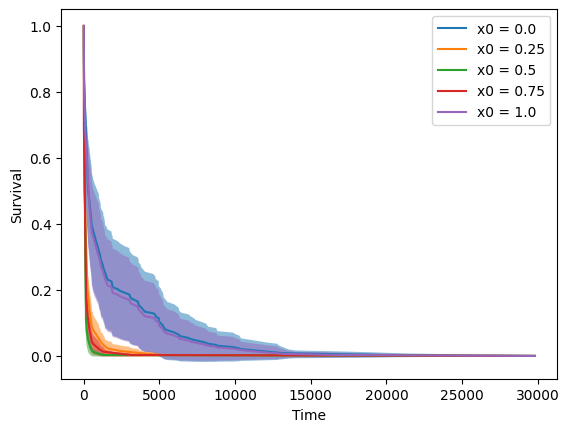

In [140]:
# Now get estimate of survival function and see how it changes with x0
new_dat = pd.DataFrame({"x0":np.linspace(0,1,5),
                        "x1":np.linspace(0,1,5),
                        "x2":np.linspace(0,1,5),
                        "x3":np.linspace(0,1,5)})

# Get model matrix using only f0
_,Xt,_ = model.predict(use_terms=[0],n_dat=new_dat)

# Now iterate over all time-points and obtain the predicted survival function + standard error estimate
# for all 5 values of x0:
S = np.zeros((len(ut),Xt.shape[0]))
VS = np.zeros((len(ut),Xt.shape[0]))
for idx,ti in enumerate(ut):

    # Su and VSu are of shape (5,1) here but will generally be of shape (Xt.shape[0],1)
    Su,VSu = PropHaz_fam.get_survival(model.coef,model.get_mmat(),sim_formula_m.y_flat[sim_formula_m.NOT_NA_flat],
                                    ti,Xt,model.lvi.T@model.lvi)
    S[idx,:] = Su.flatten()
    VS[idx,:] = VSu.flatten()

# Now we can plot the estimated survival functions + approximate cis:
for xi in range(Xt.shape[0]):

    plt.fill([*ut,*np.flip(ut)],
            [*(S[:,xi] + 1.96*VS[:,xi]),*np.flip(S[:,xi] - 1.96*VS[:,xi])],alpha=0.5)
    plt.plot(ut,S[:,xi],label=f"x0 = {new_dat["x0"][xi]}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Survival")
plt.show()

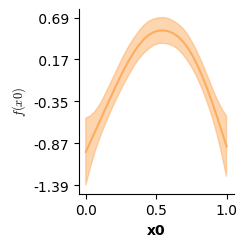

In [141]:
# Note how the main effect of x0 is reflected in the plot above:
plot(model,which=[0])

Residual plots can again be created via `plot_val` from `mssmViz` - by default Martingale residuals are returned (see Wood, 2017) for Proportional Hazard models. The example below also illustrates the use of the `gsmm_kwargs` and `gsmm_kwargs_pred` arguments of the `plot_val` function - see the doc string of the function for more details!

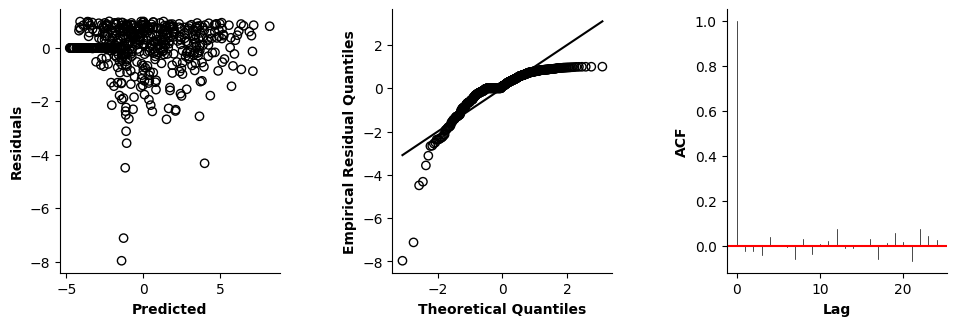

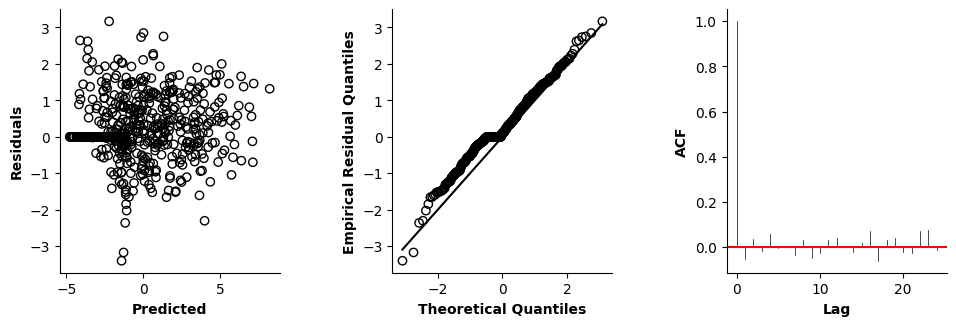

In [142]:
fig = plt.figure(figsize=(3*single_size,single_size),layout='constrained')
axs = fig.subplots(1,3,gridspec_kw={"wspace":0.2})

# Note the use of `gsmm_kwargs_pred={}` to ensure that the re-ordering is not applied to the plot against predicted values
plot_val(model,gsmm_kwargs={"reorder":res_idx},gsmm_kwargs_pred={},ar_lag=25,axs=axs)

# Can also get Deviance residuals:
fig = plt.figure(figsize=(3*single_size,single_size),layout='constrained')
axs = fig.subplots(1,3,gridspec_kw={"wspace":0.2})

plot_val(model,gsmm_kwargs={"reorder":res_idx,"resid_type":"Deviance"},gsmm_kwargs_pred={"resid_type":"Deviance"},ar_lag=25,axs=axs)

## References

**B-Splines and Difference Penalty bases**:

- Eilers, P., & Marx, B. (1996). Flexible smoothing with B-splines and penalties. Statistical Science, 11(2), 89–121. https://doi.org/10.1214/ss/1038425655
- Eilers, P., & Marx, B. (2010). Splines, knots, and penalties. https://doi.org/10.1002/WICS.125

**GAMM Estimation as implemented by `mssm`**:

- Wood, S. N. (2006). Low‐Rank Scale‐Invariant Tensor Product Smooths for Generalized Additive Mixed Models. Biometrics, 62(4), 1025–1036. https://doi.org/10.1111/j.1541-0420.2006.00574.x
- Wood, S. N. (2011). Fast stable restricted maximum likelihood and marginal likelihood estimation of semiparametric generalized linear models: Estimation of Semiparametric Generalized Linear Models. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 73(1), 3–36. https://doi.org/10.1111/j.1467-9868.2010.00749.x
- Wood, S. N., Scheipl, F., & Faraway, J. J. (2013). Straightforward intermediate rank tensor product smoothing in mixed models. Statistics and Computing, 23(3), 341–360. https://doi.org/10.1007/s11222-012-9314-z
- Wood, S. N., Goude, Y., & Shaw, S. (2015). Generalized additive models for large data sets. Journal of the Royal Statistical Society: Series C (Applied Statistics), 64(1), 139–155. https://doi.org/10.1111/rssc.12068
- Wood, S. N., Pya, N., & Säfken, B. (2016). Smoothing Parameter and Model Selection for General Smooth Models. Journal of the American Statistical Association, 111(516), 1548–1563. https://doi.org/10.1080/01621459.2016.1180986
- Wood, S. N., Li, Z., Shaddick, G., & Augustin, N. H. (2017). Generalized Additive Models for Gigadata: Modeling the U.K. Black Smoke Network Daily Data. Journal of the American Statistical Association, 112(519), 1199–1210. https://doi.org/10.1080/01621459.2016.1195744
- Wood, S. N., & Fasiolo, M. (2017). A generalized Fellner-Schall method for smoothing parameter optimization with application to Tweedie location, scale and shape models. Biometrics, 73(4), 1071–1081. https://doi.org/10.1111/biom.12666
- Krause et al. (submitted). The Mixed-Sparse-Smooth-Model Toolbox (MSSM): Efficient Estimation and Selection of Large Multi-Level Statistical Models. https://doi.org/10.48550/arXiv.2506.13132

**GAMMLSS Estimation as implemented by `mssm` & Smoothing penalty uncertainty**:

- Rigby, R. A., & Stasinopoulos, D. M. (2005). Generalized Additive Models for Location, Scale and Shape. Journal of the Royal Statistical Society Series C: Applied Statistics, 54(3), 507–554. https://doi.org/10.1111/j.1467-9876.2005.00510.x
- Wood, S. N., Pya, N., & Säfken, B. (2016). Smoothing Parameter and Model Selection for General Smooth Models. Journal of the American Statistical Association, 111(516), 1548–1563. https://doi.org/10.1080/01621459.2016.1180986
- Krause et al. (submitted). The Mixed-Sparse-Smooth-Model Toolbox (MSSM): Efficient Estimation and Selection of Large Multi-Level Statistical Models. https://doi.org/10.48550/arXiv.2506.13132


**Kernel penalties & Penalty-based model selection**:

- Marra, G., & Wood, S. N. (2011). Practical variable selection for generalized additive models. Computational Statistics & Data Analysis, 55(7), 2372–2387. https://doi.org/10.1016/j.csda.2011.02.004

**Whole-interval CIs**:

- Simpson, G. (2016). Simultaneous intervals for smooths revisited. Accessed at: https://fromthebottomoftheheap.net/2016/12/15/simultaneous-interval-revisited/

**GAMMS in general & Overview**:

- Wood, S. N. (2020). Inference and computation with generalized additive models and their extensions. TEST, 29(2), 307–339. https://doi.org/10.1007/s11749-020-00711-5
- Wood, S. N. (2017). Generalized Additive Models: An Introduction with R, Second Edition (2nd ed.). Chapman and Hall/CRC.